In [1]:
# !pip install mealpy
# !pip install pyswarm
# !pip install scikit-optimize
# !pip install pyswarms

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mealpy.swarm_based.PSO import OriginalPSO
from pyswarm import pso
from mealpy.utils.problem import Problem
from mealpy.utils.space import IntegerVar, FloatVar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.linear_model import LinearRegression
import pyswarms as ps
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from pyswarm import pso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras import backend as K
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# importing the libraries and dataframe

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_combined_boxplot(welldata, inputs, title="Boxplots", filename="boxplots.png"):
    # Split inputs into chunks
    inputs_split = [inputs[:10], inputs[10:20], inputs[20:30],  inputs[30:45]]
    n_rows = len(inputs_split)
    n_cols = max(len(group) for group in inputs_split)

    # Create figure and axes
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 5), squeeze=False)

    # Plotting each group
    for i, input_group in enumerate(inputs_split):
        for j in range(n_cols):
            if j < len(input_group):
                ax = axs[i, j]
                sns.boxplot(
                    y=welldata[input_group[j]],
                    ax=ax,
                    color='cornflowerblue',
                    showmeans=True,
                    meanprops={
                        "marker": "o", "markerfacecolor": "white",
                        "markeredgecolor": "black", "markersize": 10
                    },
                    flierprops={
                        'marker': 'o', 'markerfacecolor': 'darkgreen',
                        'markeredgecolor': 'darkgreen'
                    }
                )
                ax.set_title(input_group[j], fontsize=10)
                ax.set_ylabel('')
            else:
                fig.delaxes(axs[i, j])  # Remove empty subplots

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for the title
    plt.savefig(filename, dpi=300)
    plt.show()

In [4]:
df = pd.read_csv('Pilot Plant Data UTF enc - publish version.csv')
df.dropna(inplace=True)
print(df)

                                  RUN No.      2312-PP-01     2312-PP-02R  \
0                           Avg ROT ( °C)           651.6           649.4   
1                      System P (kg/cm2g)             0.5             0.5   
2                                Catalyst           CAT-A           CAT-A   
3                         STM.(% of feed)              15            14.9   
4                                    Feed  Gas Condensate  Gas Condensate   
5                         Feed rate (g/h)             500             502   
6                        Mass balance (%)            95.3            97.8   
7                                 Cat/Oil            25.8            32.2   
8                          Conversion (%)            92.7            93.3   
10                                     H2            0.31            0.28   
11                                     C1            6.44            5.53   
12                                     C2             3.8            3.36   

# Preliminary Data Analysis (PDA) 

In [5]:
df2 = df.T.reset_index()  # if you're transposing and want clean row indices
df2.columns = df2.iloc[0]     # Set first row as header
df2 = df2[1:].reset_index(drop=True)

In [6]:
df2.columns

Index(['RUN No.', 'Avg ROT ( °C)', 'System P (kg/cm2g)', 'Catalyst',
       'STM.(% of feed)', 'Feed', 'Feed rate (g/h)', 'Mass balance (%)',
       'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=',
       'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas',
       'Gasoline (36-219C)', 'LCO (219-359C)', 'HCO (359C+)', 'Coke',
       'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=',
       'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4',
       'Res Time based on exit cond, (second)', 'Feed T (ºC)',
       'Catalyst T  (ºC)', 'Reactor N2 (LPH)'],
      dtype='object', name=0)

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   RUN No.                                28 non-null     object
 1   Avg ROT ( °C)                          28 non-null     object
 2   System P (kg/cm2g)                     28 non-null     object
 3   Catalyst                               28 non-null     object
 4   STM.(% of feed)                        28 non-null     object
 5   Feed                                   28 non-null     object
 6   Feed rate (g/h)                        28 non-null     object
 7   Mass balance (%)                       28 non-null     object
 8   Cat/Oil                                28 non-null     object
 9   Conversion (%)                         28 non-null     object
 10  H2                                     28 non-null     object
 11  C1                   

In [8]:
for col in df2.columns:
    try:
        df2[col] = df2[col].astype(float)
    except ValueError:
        df2[col] = df2[col].astype(str)

In [9]:
#separating data
tags = df2[['RUN No.', 'Catalyst', 'Feed']]
data = df2.drop(columns =['RUN No.', 'Catalyst', 'Feed'])
targets = df2[['Conversion (%)', 'Gasoline (36-219C)']]

Avg ROT ( °C)
Skew : -0.29


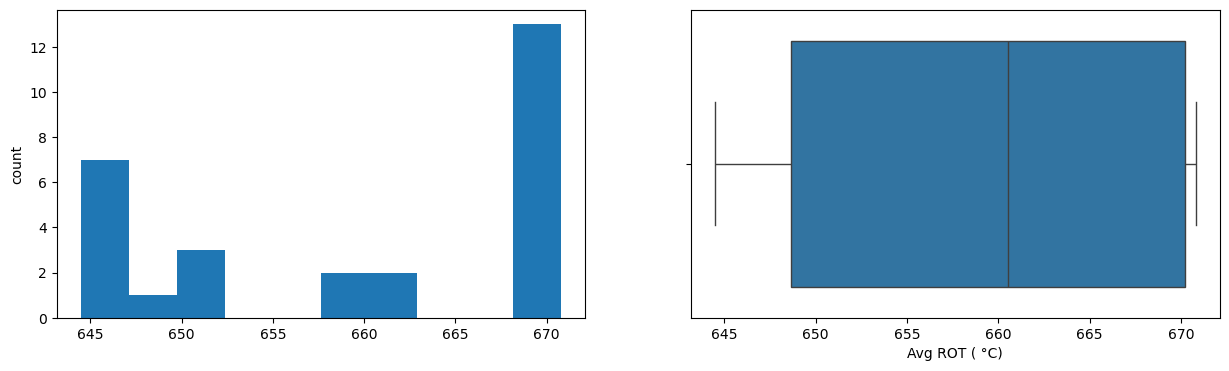

System P (kg/cm2g)
Skew : -1.0


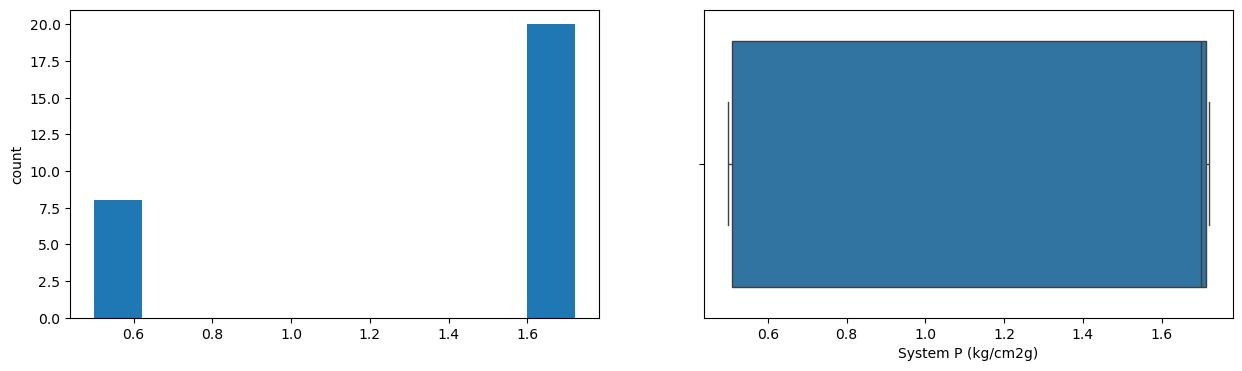

STM.(% of feed)
Skew : 1.74


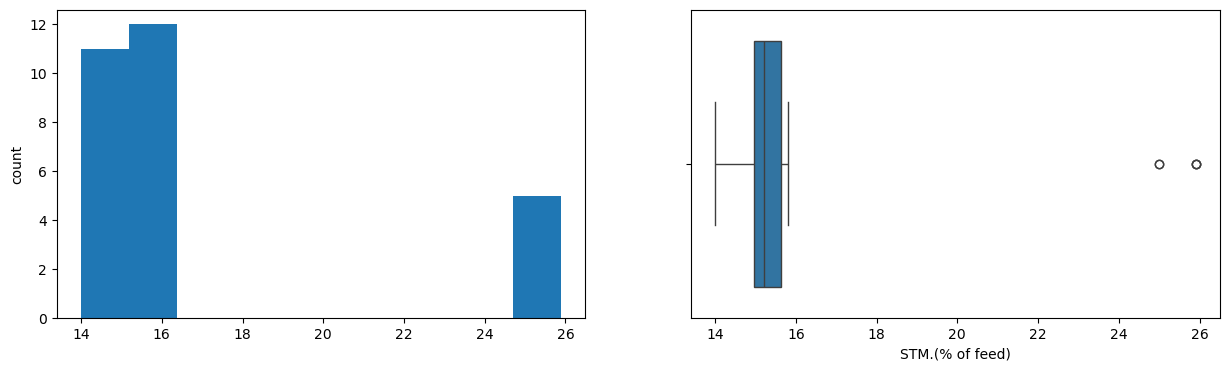

Feed rate (g/h)
Skew : 2.69


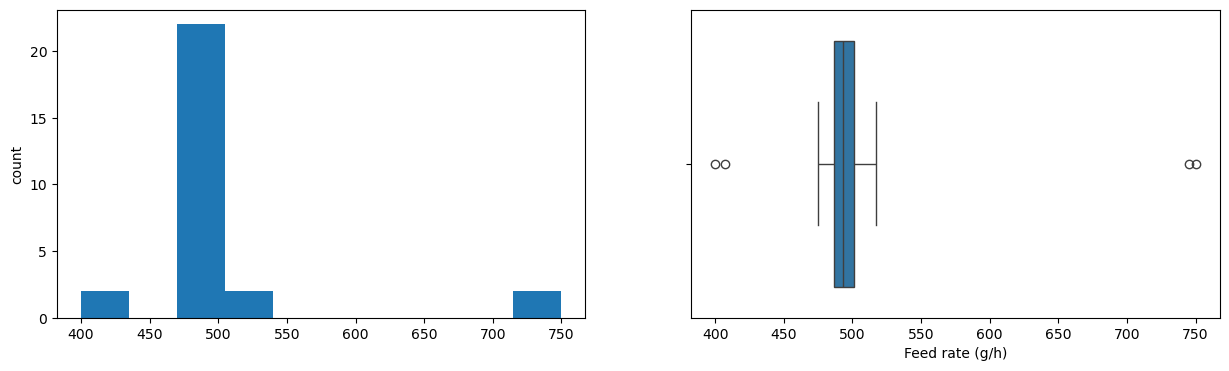

Mass balance (%)
Skew : -0.8


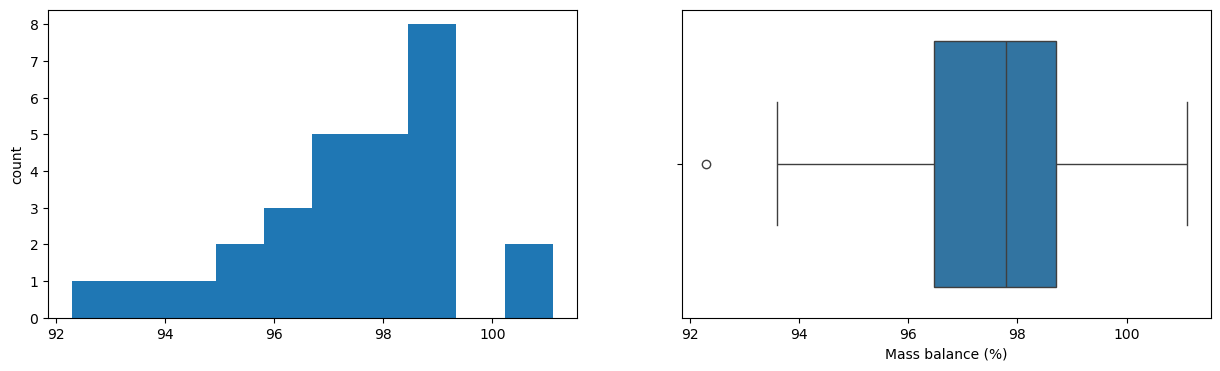

Cat/Oil
Skew : -1.03


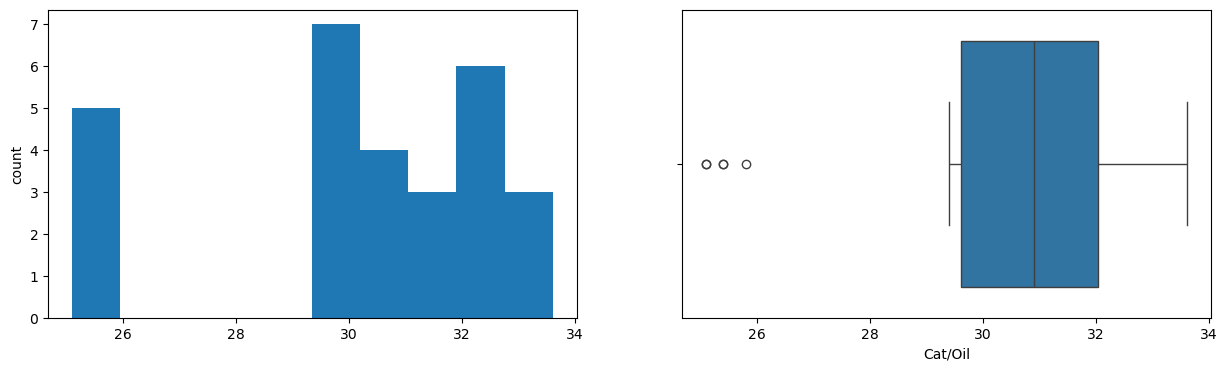

Conversion (%)
Skew : -0.16


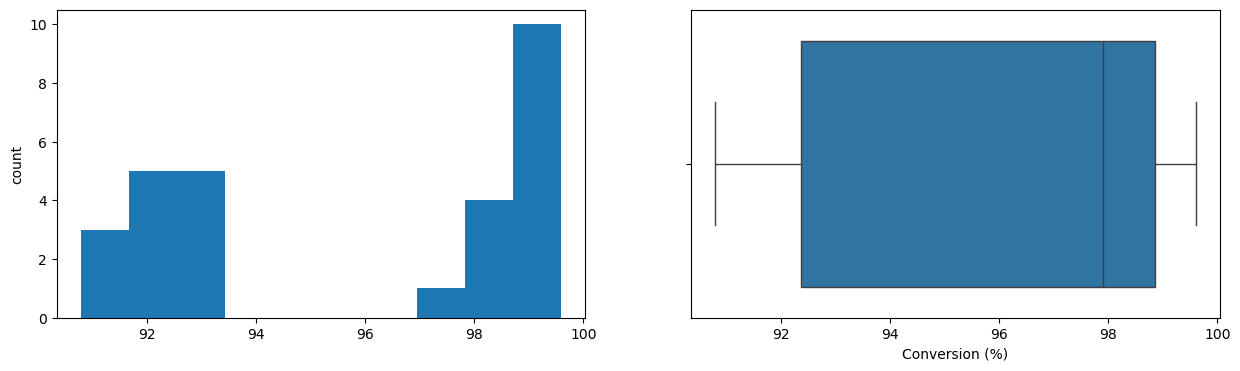

H2
Skew : -0.08


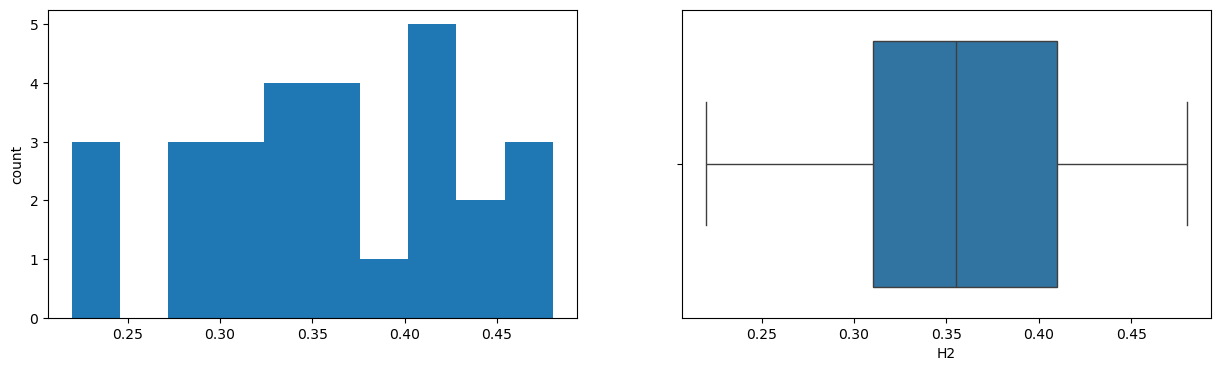

C1
Skew : 0.57


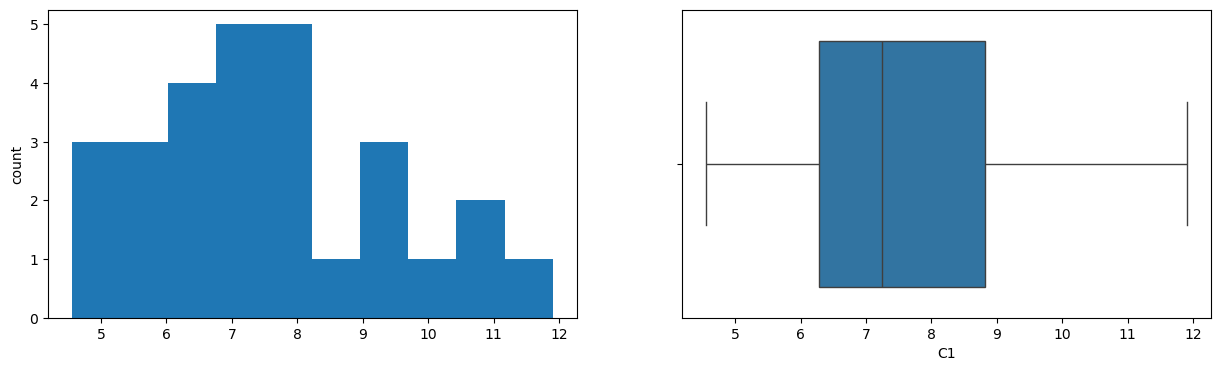

C2
Skew : 0.36


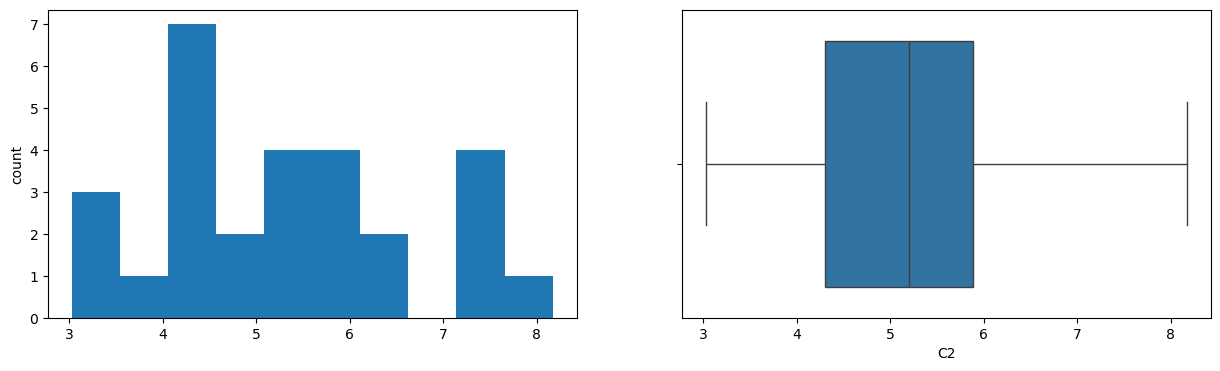

C2=
Skew : 0.03


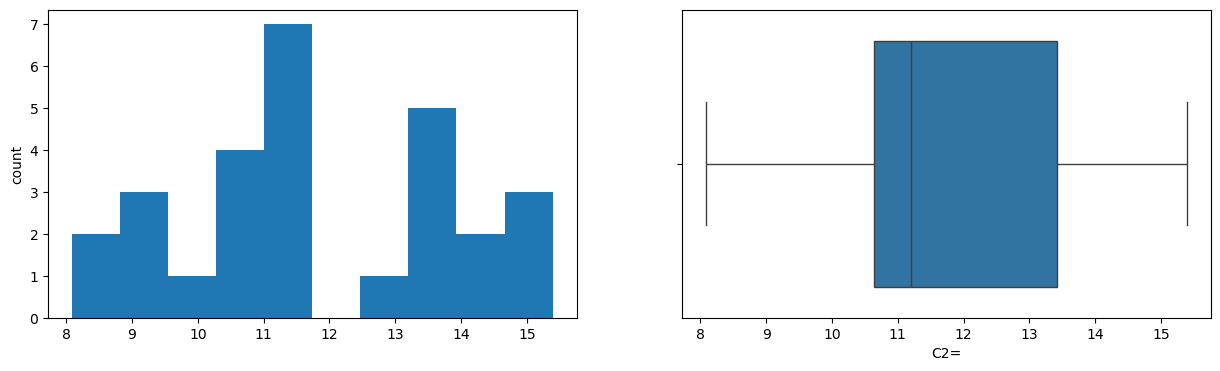

C3
Skew : 0.4


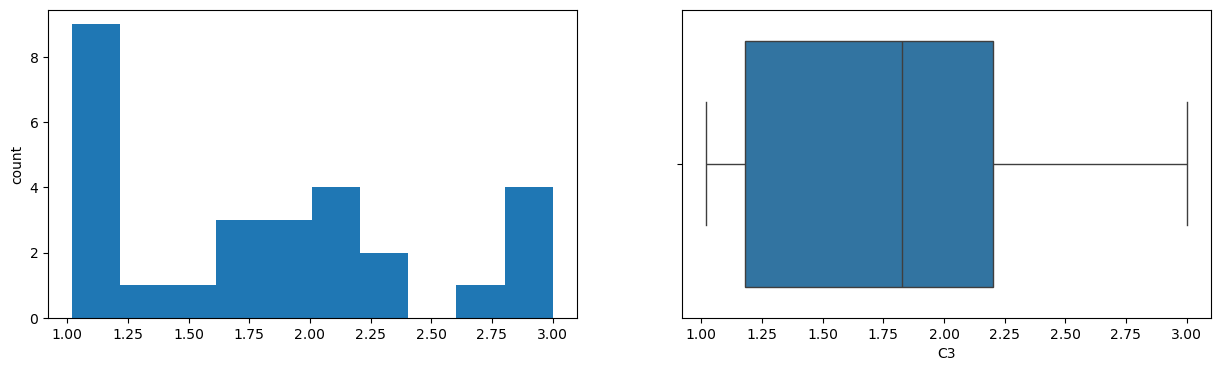

C3=
Skew : -0.38


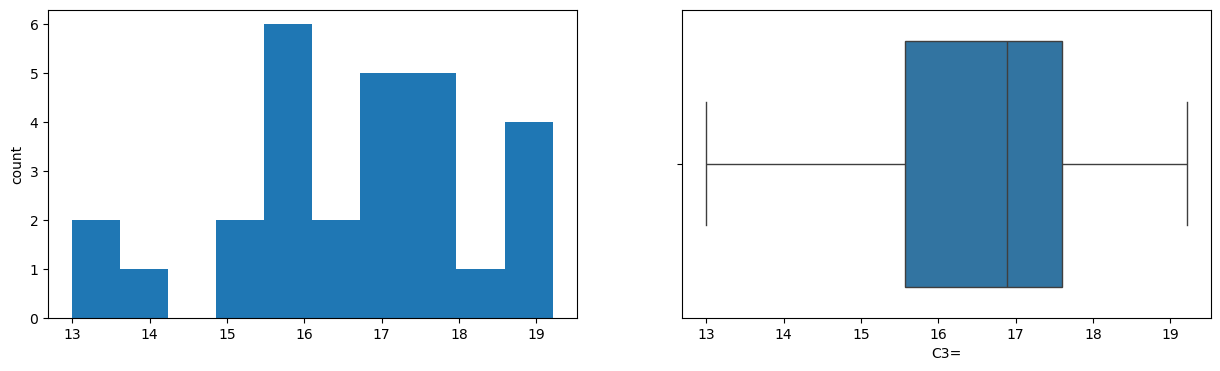

iC4
Skew : 1.11


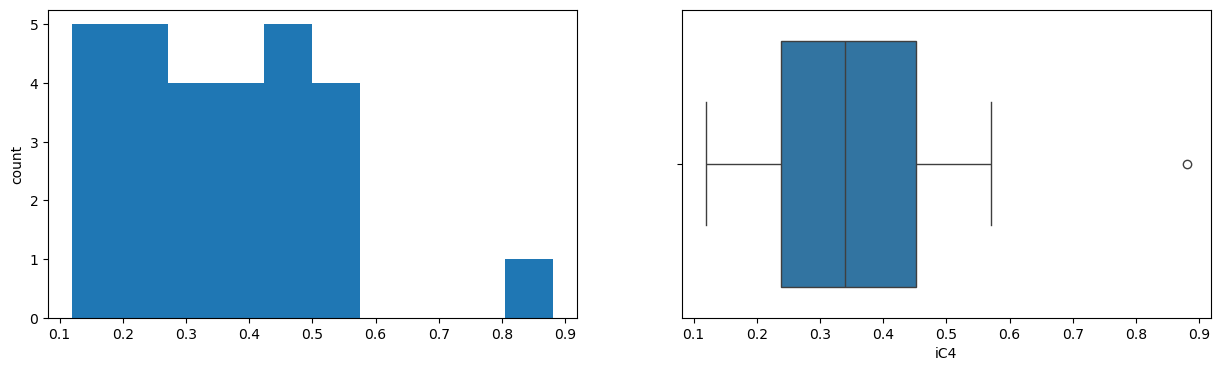

nC4
Skew : 0.06


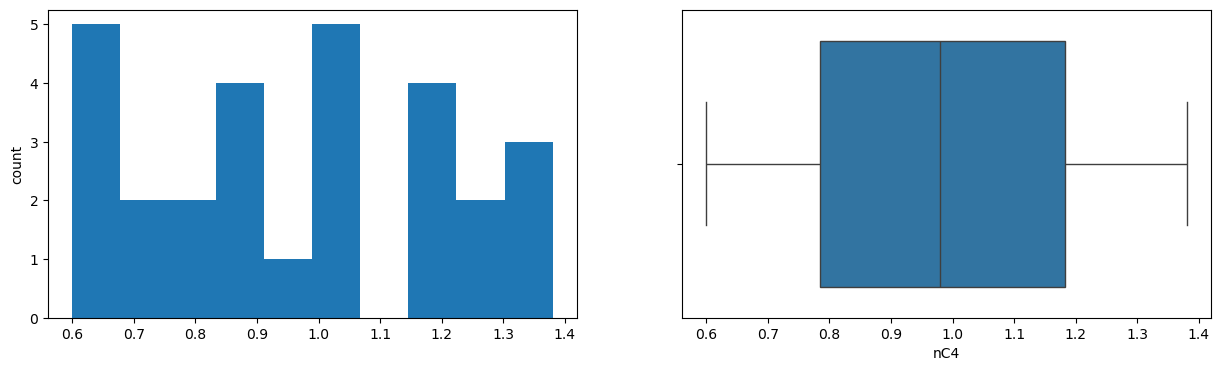

t2C4=
Skew : -0.28


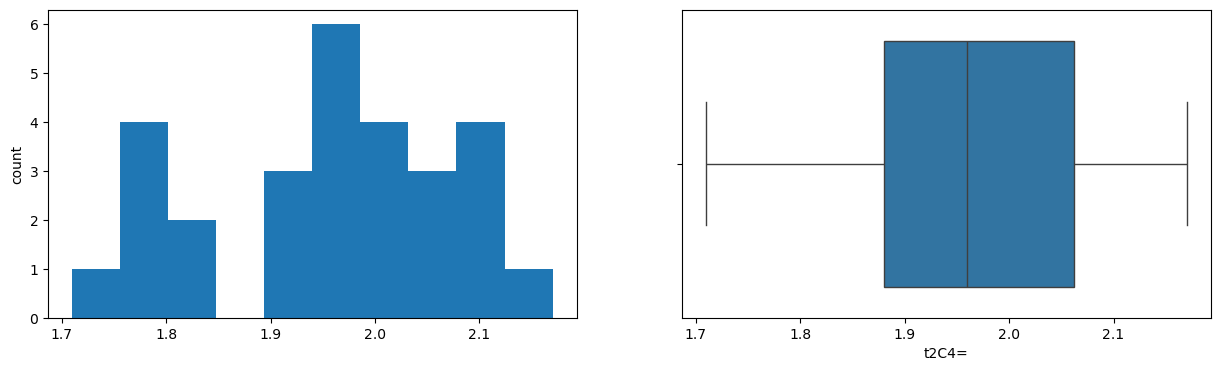

1C4=
Skew : -0.08


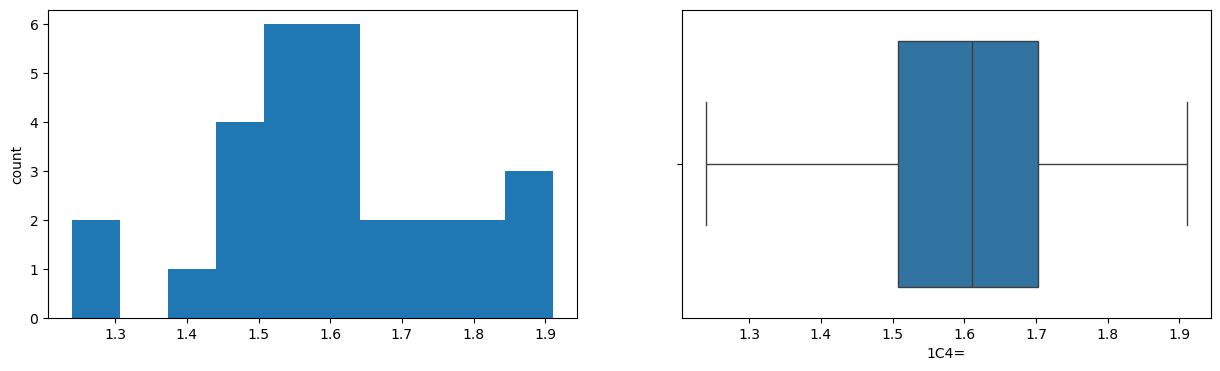

iC4=
Skew : 0.42


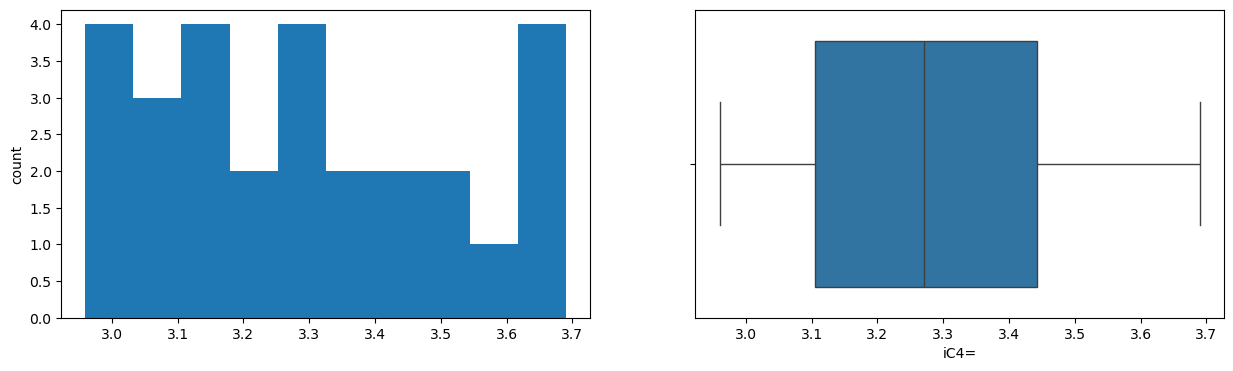

c2C4=
Skew : -0.23


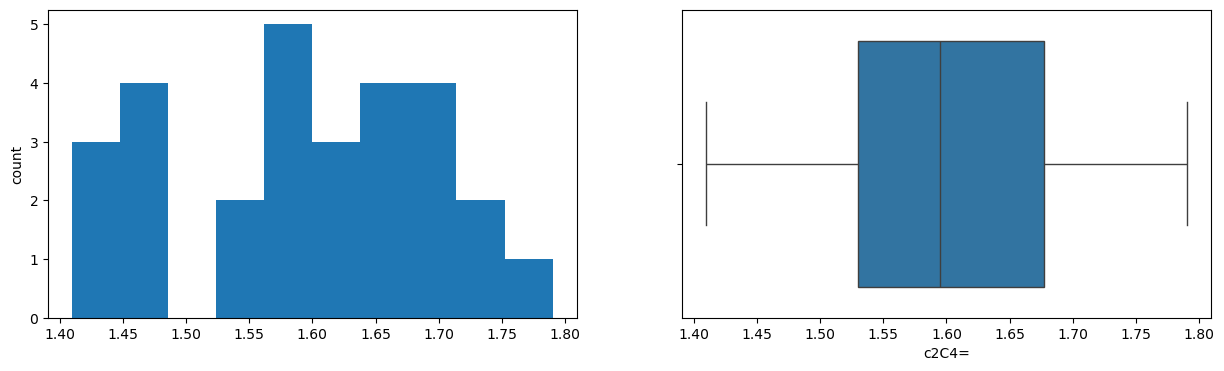

1,3-BD
Skew : 0.89


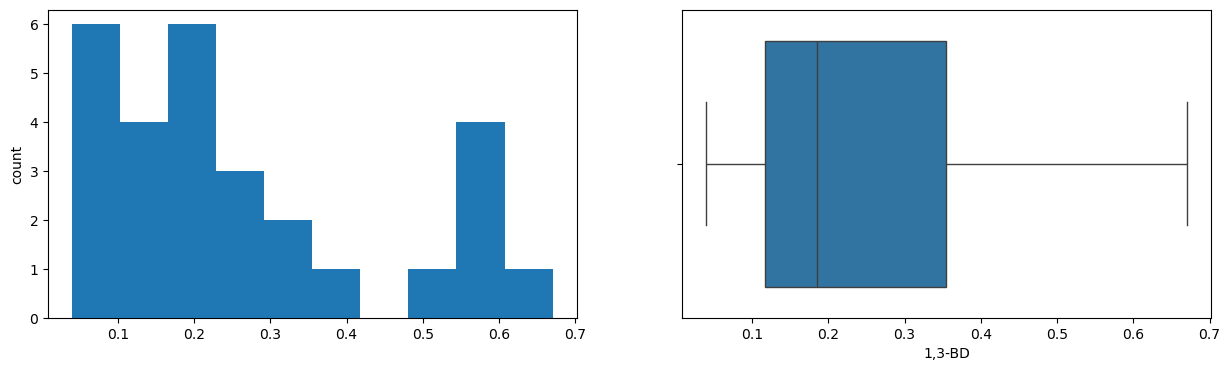

Total Gas
Skew : 0.24


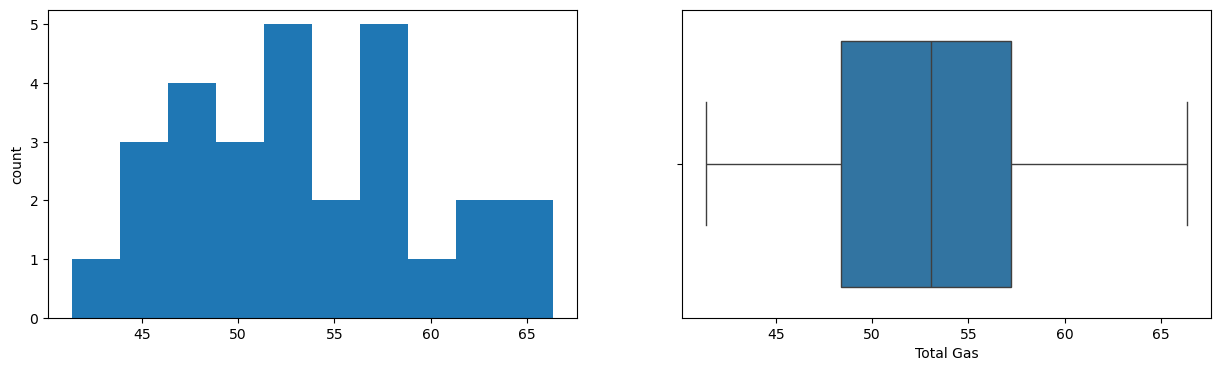

Gasoline (36-219C)
Skew : 0.29


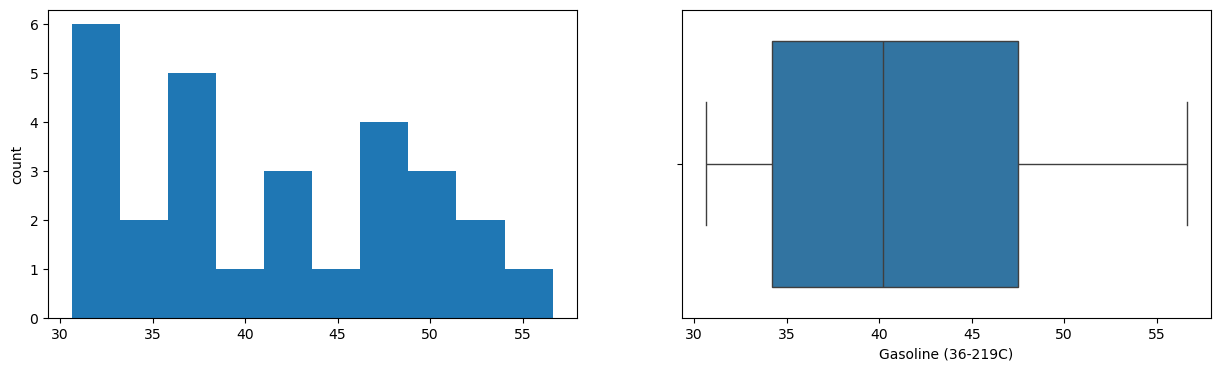

LCO (219-359C)
Skew : 0.15


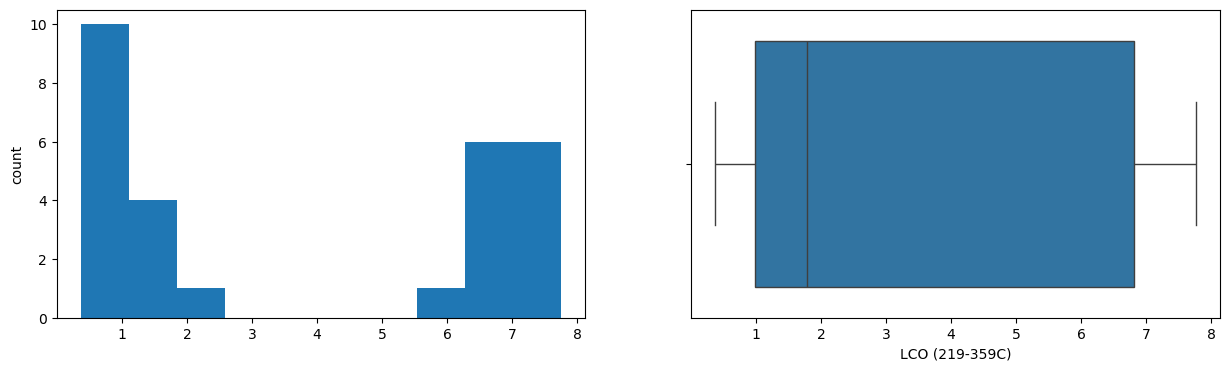

HCO (359C+)
Skew : 0.61


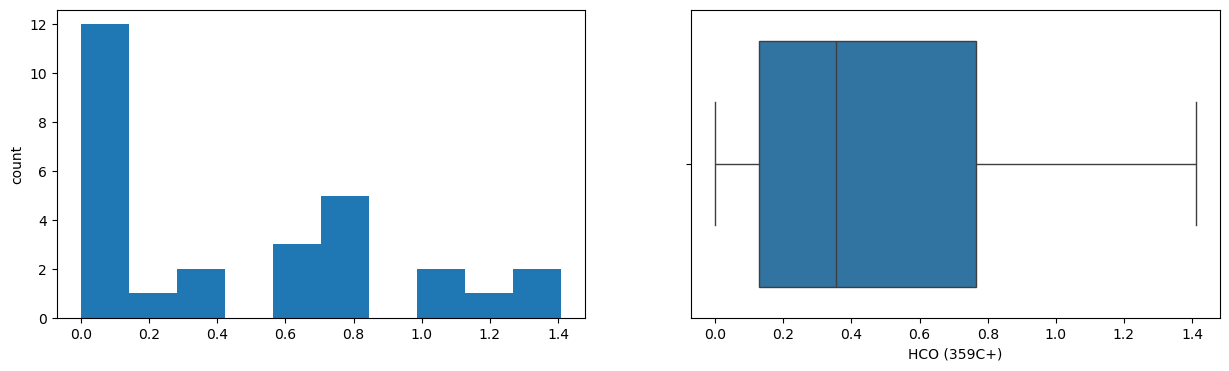

Coke
Skew : 0.38


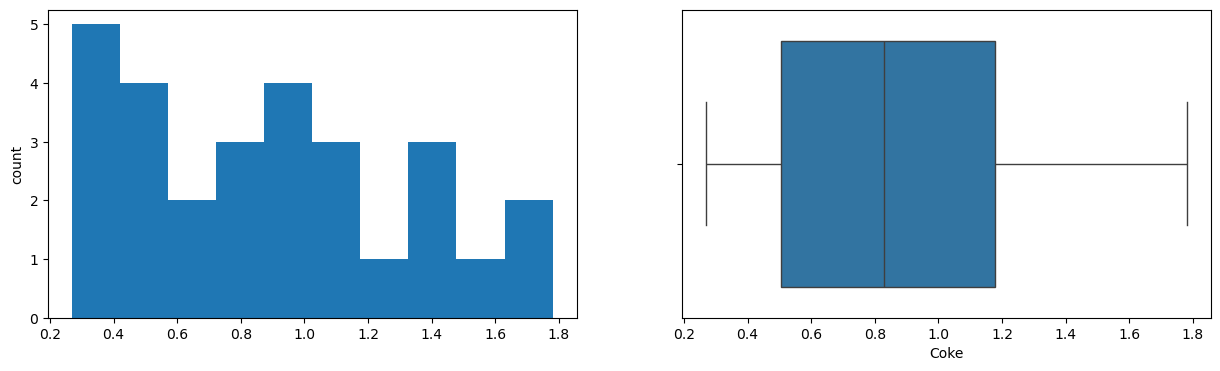

H2-C2 (dry gas)
Skew : 0.35


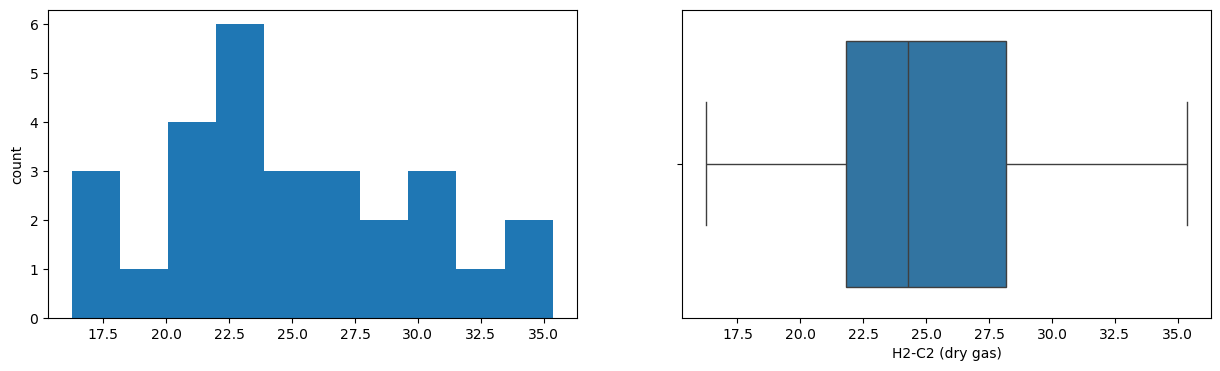

C3-C4 (LPG)
Skew : -0.74


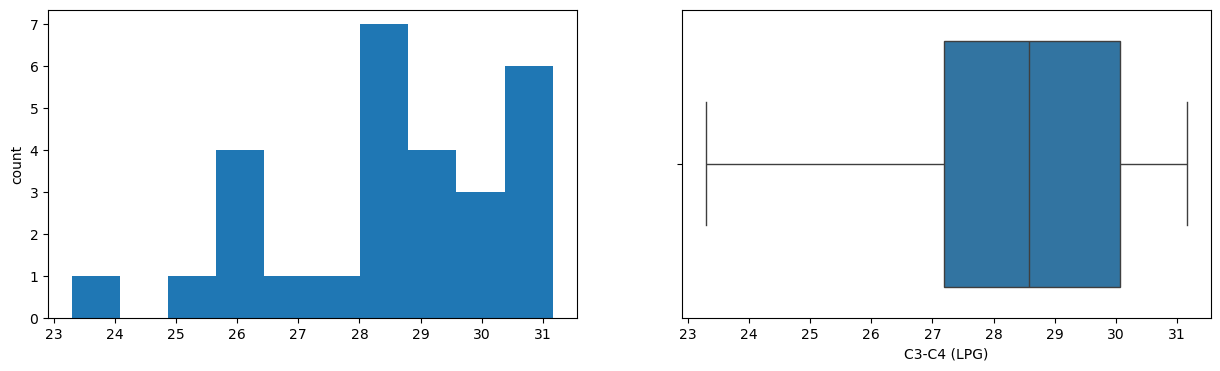

C2=-C4= (Light olefins)
Skew : -0.25


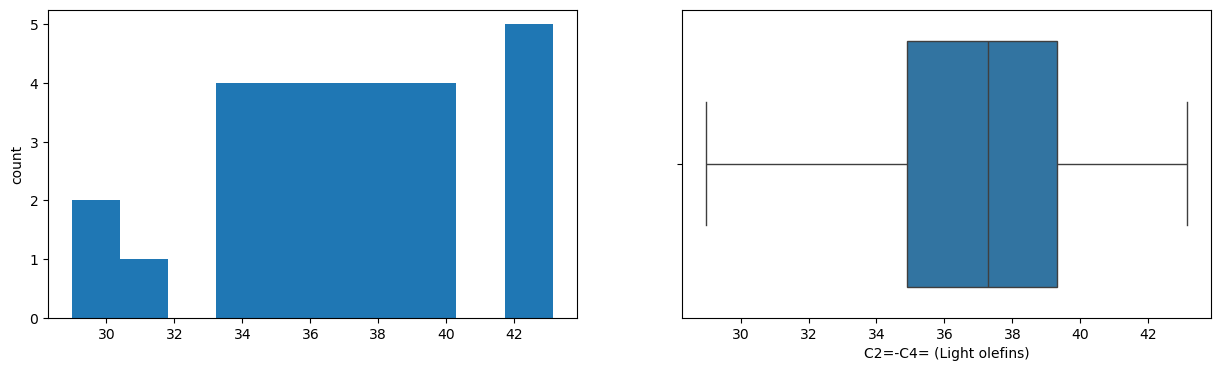

C3=+C4=
Skew : -0.63


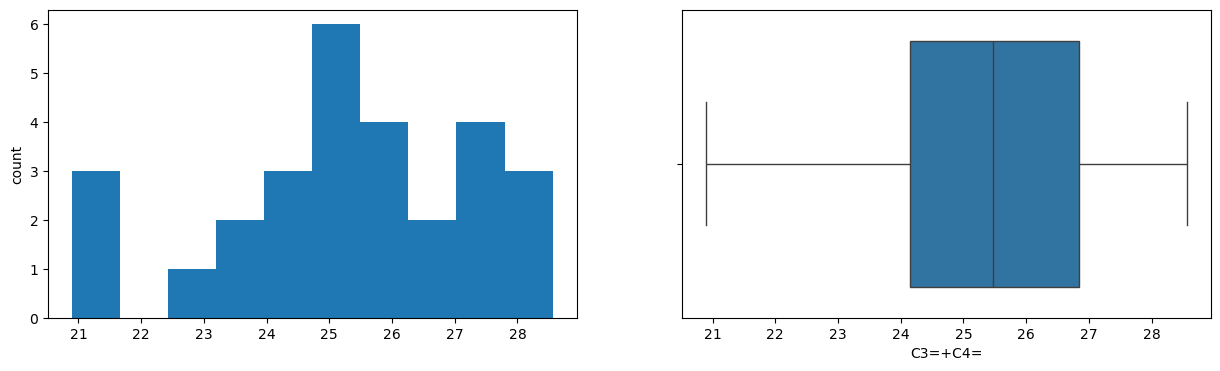

C4= (Butenes)
Skew : 0.45


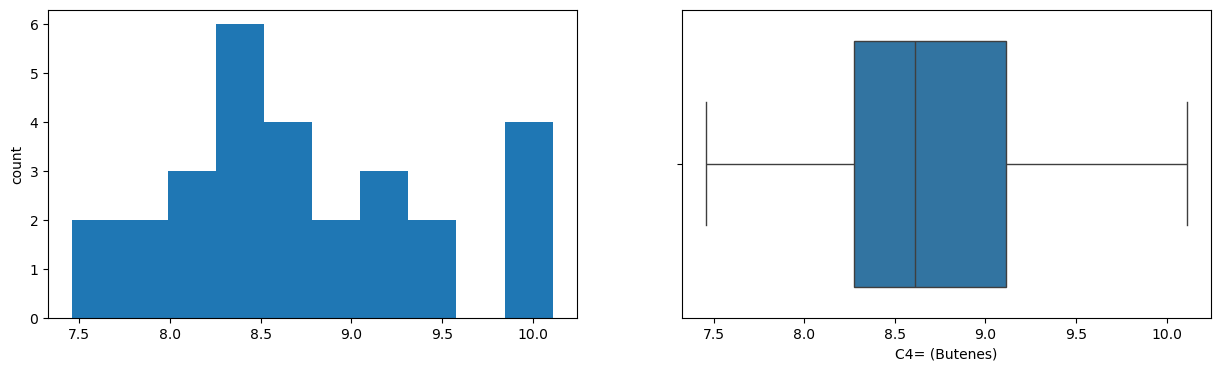

C2=/C2
Skew : 0.73


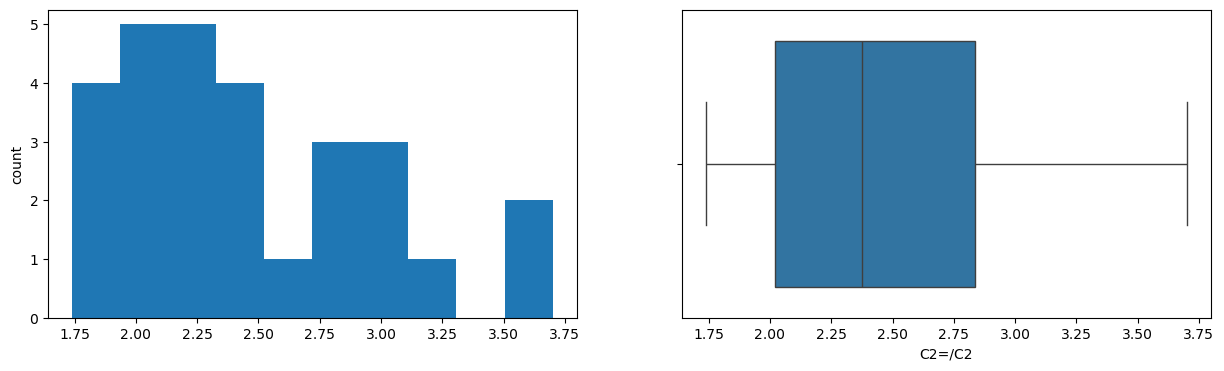

C3=/C3
Skew : 0.35


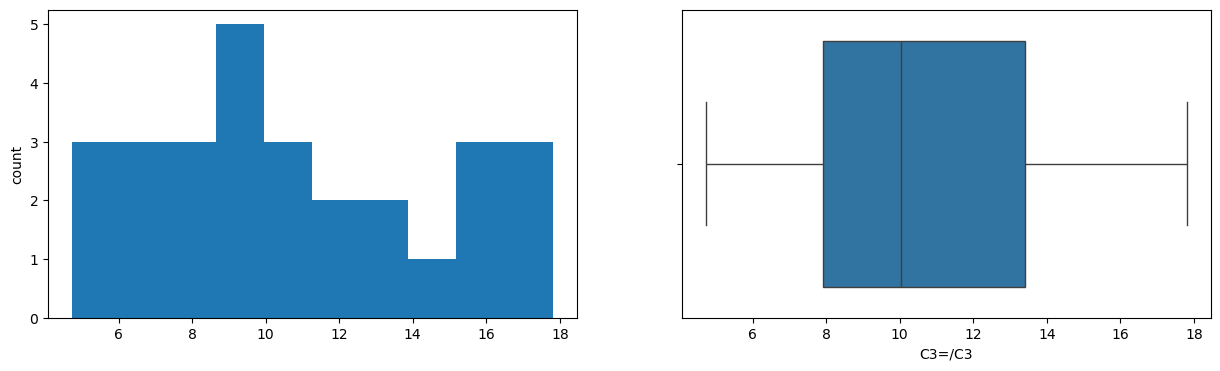

C4=/C4
Skew : 0.86


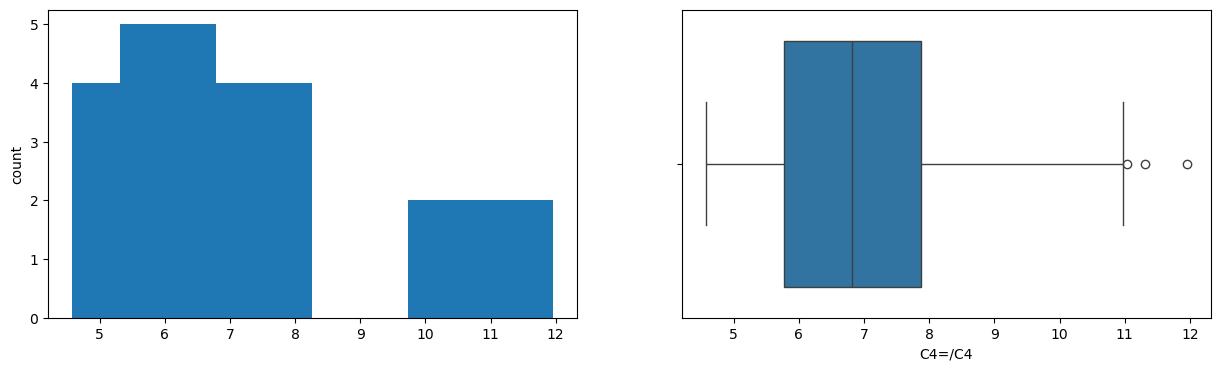

iC4=/C4=
Skew : 0.13


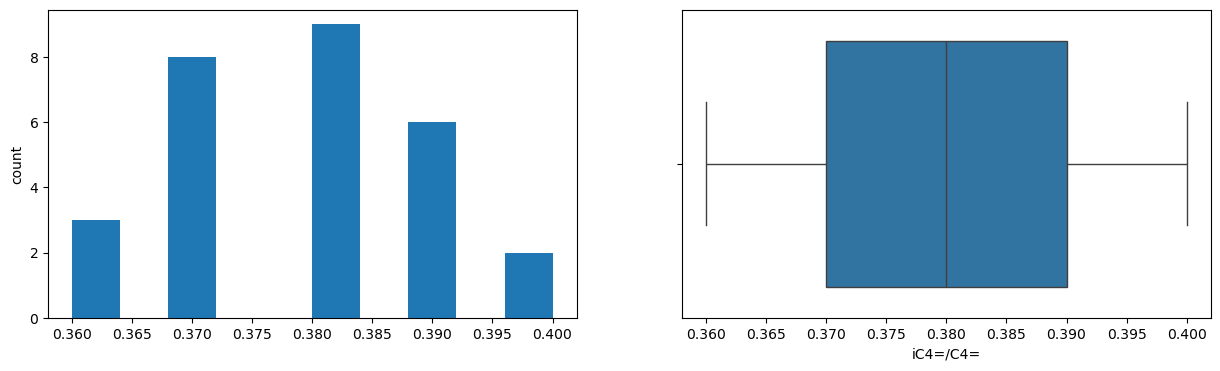

iC4=/iC4
Skew : 1.29


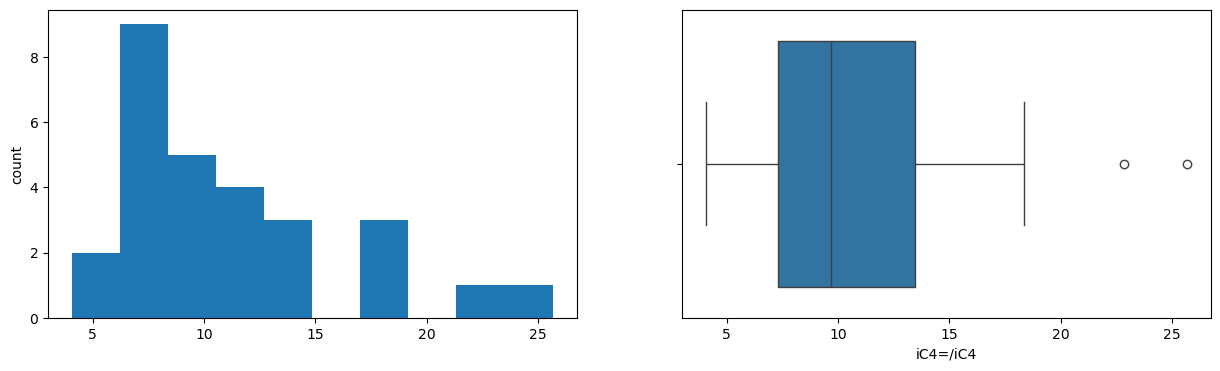

Res Time based on exit cond, (second)
Skew : -0.72


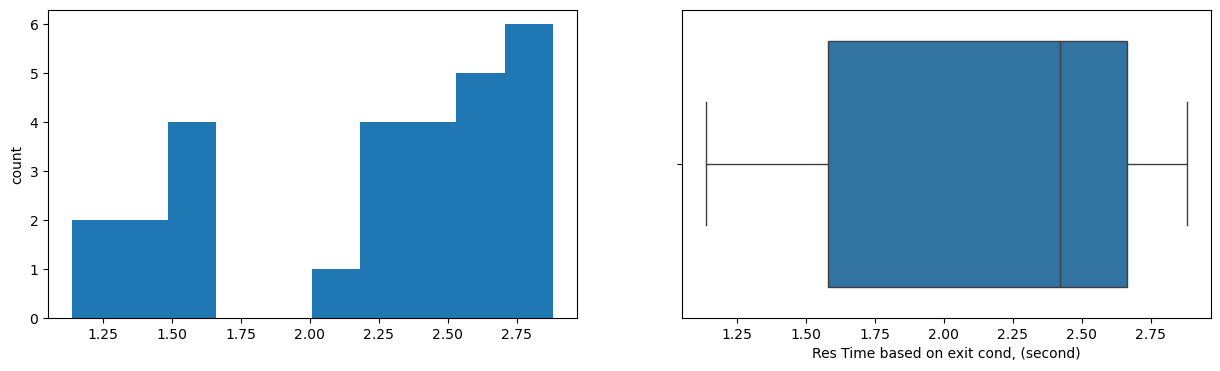

Feed T (ºC)
Skew : 0.25


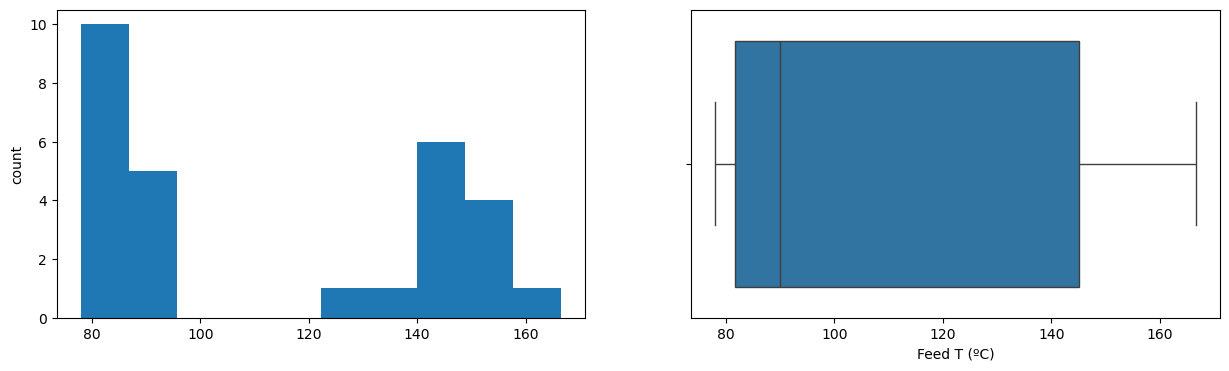

Catalyst T  (ºC)
Skew : -2.03


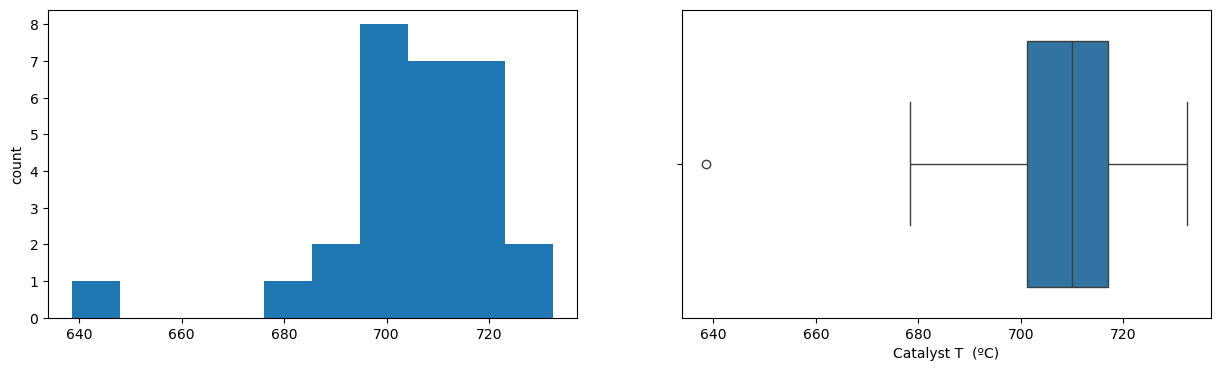

Reactor N2 (LPH)
Skew : -0.19


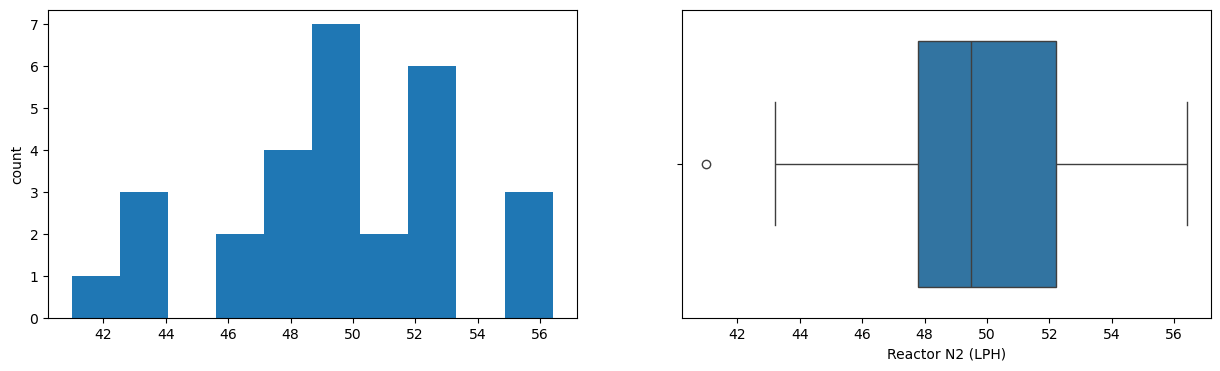

In [10]:
for col in data:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

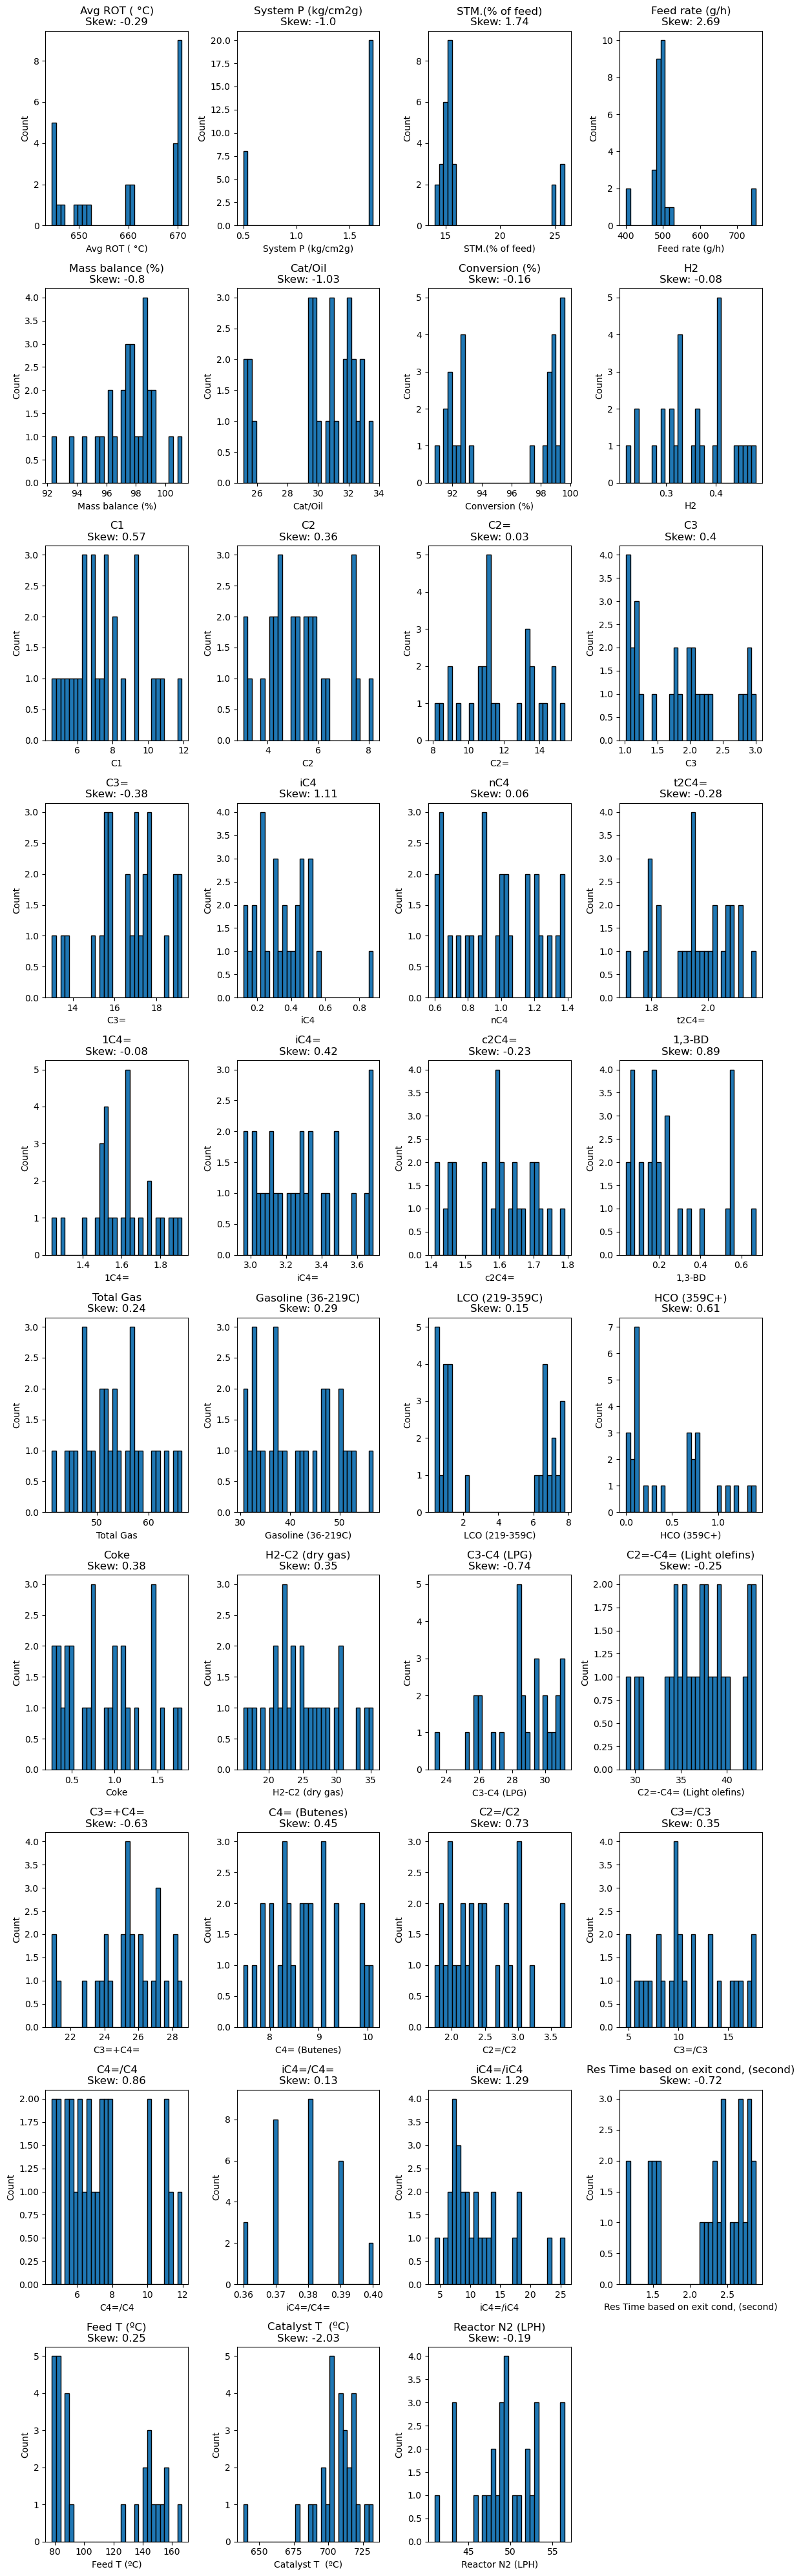

In [11]:
import matplotlib.pyplot as plt
import math

# Number of histograms per row
n_cols = 4
n_features = len(data.columns)
n_rows = math.ceil(n_features / n_cols)

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten in case we have multiple rows

# Plot each histogram
for i, col in enumerate(data.columns):
    axes[i].hist(data[col], bins=30, edgecolor='black')
    axes[i].set_title(f'{col}\nSkew: {round(data[col].skew(), 2)}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save
plt.tight_layout()
plt.savefig("all_histograms_subplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Removing outliers

['Avg ROT ( °C)', 'System P (kg/cm2g)', 'STM.(% of feed)', 'Feed rate (g/h)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline (36-219C)', 'LCO (219-359C)', 'HCO (359C+)', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4', 'Res Time based on exit cond, (second)', 'Feed T (ºC)', 'Catalyst T  (ºC)', 'Reactor N2 (LPH)']


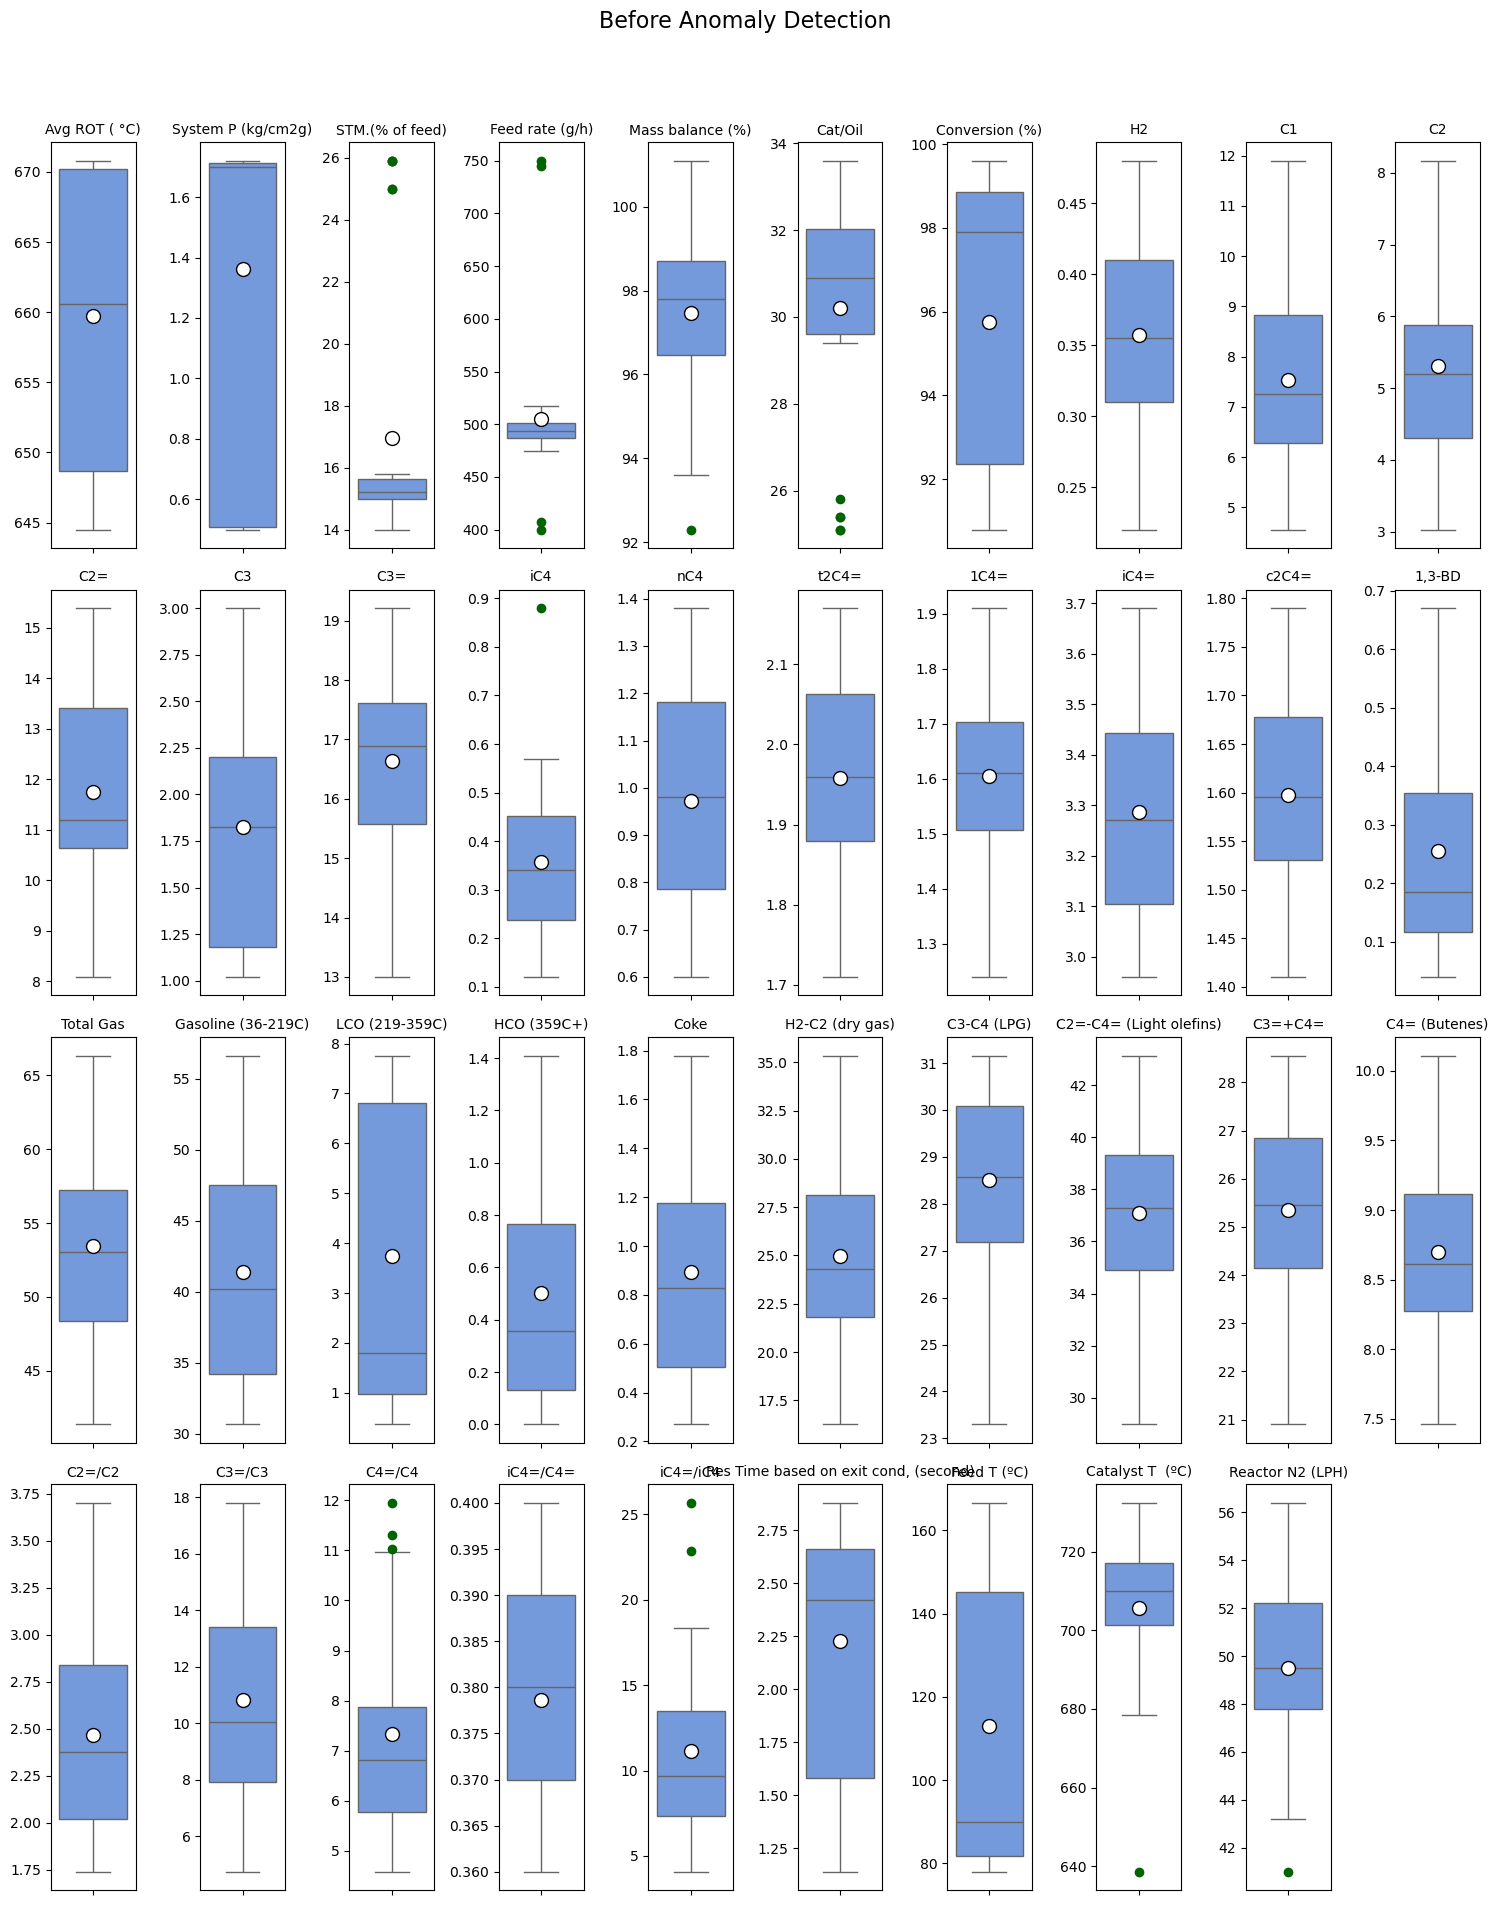

In [12]:
#Check the new columns which shows the anomaly
inputs = list(data.columns)
# Before anomaly detection
print(inputs)
make_combined_boxplot(data, inputs, title="Before Anomaly Detection", filename="boxplots_before.png")


In [13]:
# Create a copy of the dataframe so that the original remanins untouched and extract the required curves
anomaly_df = data.copy()

# Drop any null values. This method drops the entire row of data if one of the cells in that row
# contains a null (NaN) value
anomaly_df.dropna(inplace=True)

# Define the inputs for the anomaly detection
anomaly_inputs = ['Avg ROT ( °C)', 'System P (kg/cm2g)', 'STM.(% of feed)', 'Feed rate (g/h)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline (36-219C)', 'LCO (219-359C)', 'HCO (359C+)', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4', 'Res Time based on exit cond, (second)', 'Feed T (ºC)', 'Catalyst T  (ºC)', 'Reactor N2 (LPH)']

# Setup the models, each will have a contamination (outlier) fraction of 0.1
# The random_state is set to allow repeatable results for the Isolation Forest. This can be omitted if required.
model_IF = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), max_features=1.0, random_state=42)
model_SVM = OneClassSVM(nu=0.10)
model_lof = LocalOutlierFactor(contamination=0.1, novelty=True)

models = {'IF':model_IF,
         'SVM': model_SVM,
         'LOF': model_lof}

for name, model in models.items():
    print(f'Fitting: {name}')
    model.fit(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly_scores'] = model.decision_function(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly'] = model.predict(anomaly_df[anomaly_inputs])

# Identify common anomalies across all models (where each model flags the row as an anomaly)
# Common anomaly will be when all models predict -1 (anomaly)
anomaly_df['common_anomaly'] = (anomaly_df[['IF_anomaly', 'SVM_anomaly', 'LOF_anomaly']] == -1).all(axis=1)

print('Model Fitting Complete')
anomaly_df.head(5)

Fitting: IF
Fitting: SVM
Fitting: LOF
Model Fitting Complete


,Avg ROT ( °C),System P (kg/cm2g),STM.(% of feed),Feed rate (g/h),Mass balance (%),Cat/Oil,Conversion (%),H2,C1,C2,...,Feed T (ºC),Catalyst T (ºC),Reactor N2 (LPH),IF_anomaly_scores,IF_anomaly,SVM_anomaly_scores,SVM_anomaly,LOF_anomaly_scores,LOF_anomaly,common_anomaly
0,651.6,0.5,15.0,500.0,95.3,25.8,92.7,0.31,6.44,3.80,...,147.7,709.7,43.2,0.052665,1,5.541219e-02,1,0.290266,1,False
1,649.4,0.5,14.9,502.0,97.8,32.2,93.3,0.28,5.53,3.36,...,151.4,686.5,43.2,0.021008,1,5.528106e-02,1,0.278453,1,False
2,650.7,0.5,15.3,745.0,97.2,25.4,92.6,0.24,4.88,3.14,...,153.1,696.1,43.2,0.005103,1,1.490422e-08,1,-1.811392,-1,False
3,650.6,0.5,15.2,750.0,98.3,29.4,92.6,0.22,4.56,3.03,...,156.3,678.4,49.7,-0.011908,-1,-5.415246e-03,-1,-1.860647,-1,True
4,645.7,1.7,15.2,494.0,99.3,25.4,92.6,0.33,8.15,5.19,...,155.1,721.1,49.6,0.076622,1,5.066941e-02,1,0.277018,1,False


In [14]:
data.isna().sum()

0
Avg ROT ( °C)                            0
System P (kg/cm2g)                       0
STM.(% of feed)                          0
Feed rate (g/h)                          0
Mass balance (%)                         0
Cat/Oil                                  0
Conversion (%)                           0
H2                                       0
C1                                       0
C2                                       0
C2=                                      0
C3                                       0
C3=                                      0
iC4                                      0
nC4                                      0
t2C4=                                    0
1C4=                                     0
iC4=                                     0
c2C4=                                    0
1,3-BD                                   0
Total Gas                                0
Gasoline (36-219C)                       0
LCO (219-359C)                           0
HCO (359C

In [15]:
(anomaly_df['common_anomaly'] == True).value_counts()

common_anomaly
False    27
True      1
Name: count, dtype: int64

In [16]:
data_filtered = data.loc[~anomaly_df['common_anomaly']]

In [17]:
print(data_filtered[['Avg ROT ( °C)', 'Reactor N2 (LPH)']].isnull().sum())
print(data_filtered[['Avg ROT ( °C)', 'Reactor N2 (LPH)']].count())

0
Avg ROT ( °C)       0
Reactor N2 (LPH)    0
dtype: int64
0
Avg ROT ( °C)       27
Reactor N2 (LPH)    27
dtype: int64


['Avg ROT ( °C)', 'System P (kg/cm2g)', 'STM.(% of feed)', 'Feed rate (g/h)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline (36-219C)', 'LCO (219-359C)', 'HCO (359C+)', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4', 'Res Time based on exit cond, (second)', 'Feed T (ºC)', 'Catalyst T  (ºC)', 'Reactor N2 (LPH)']


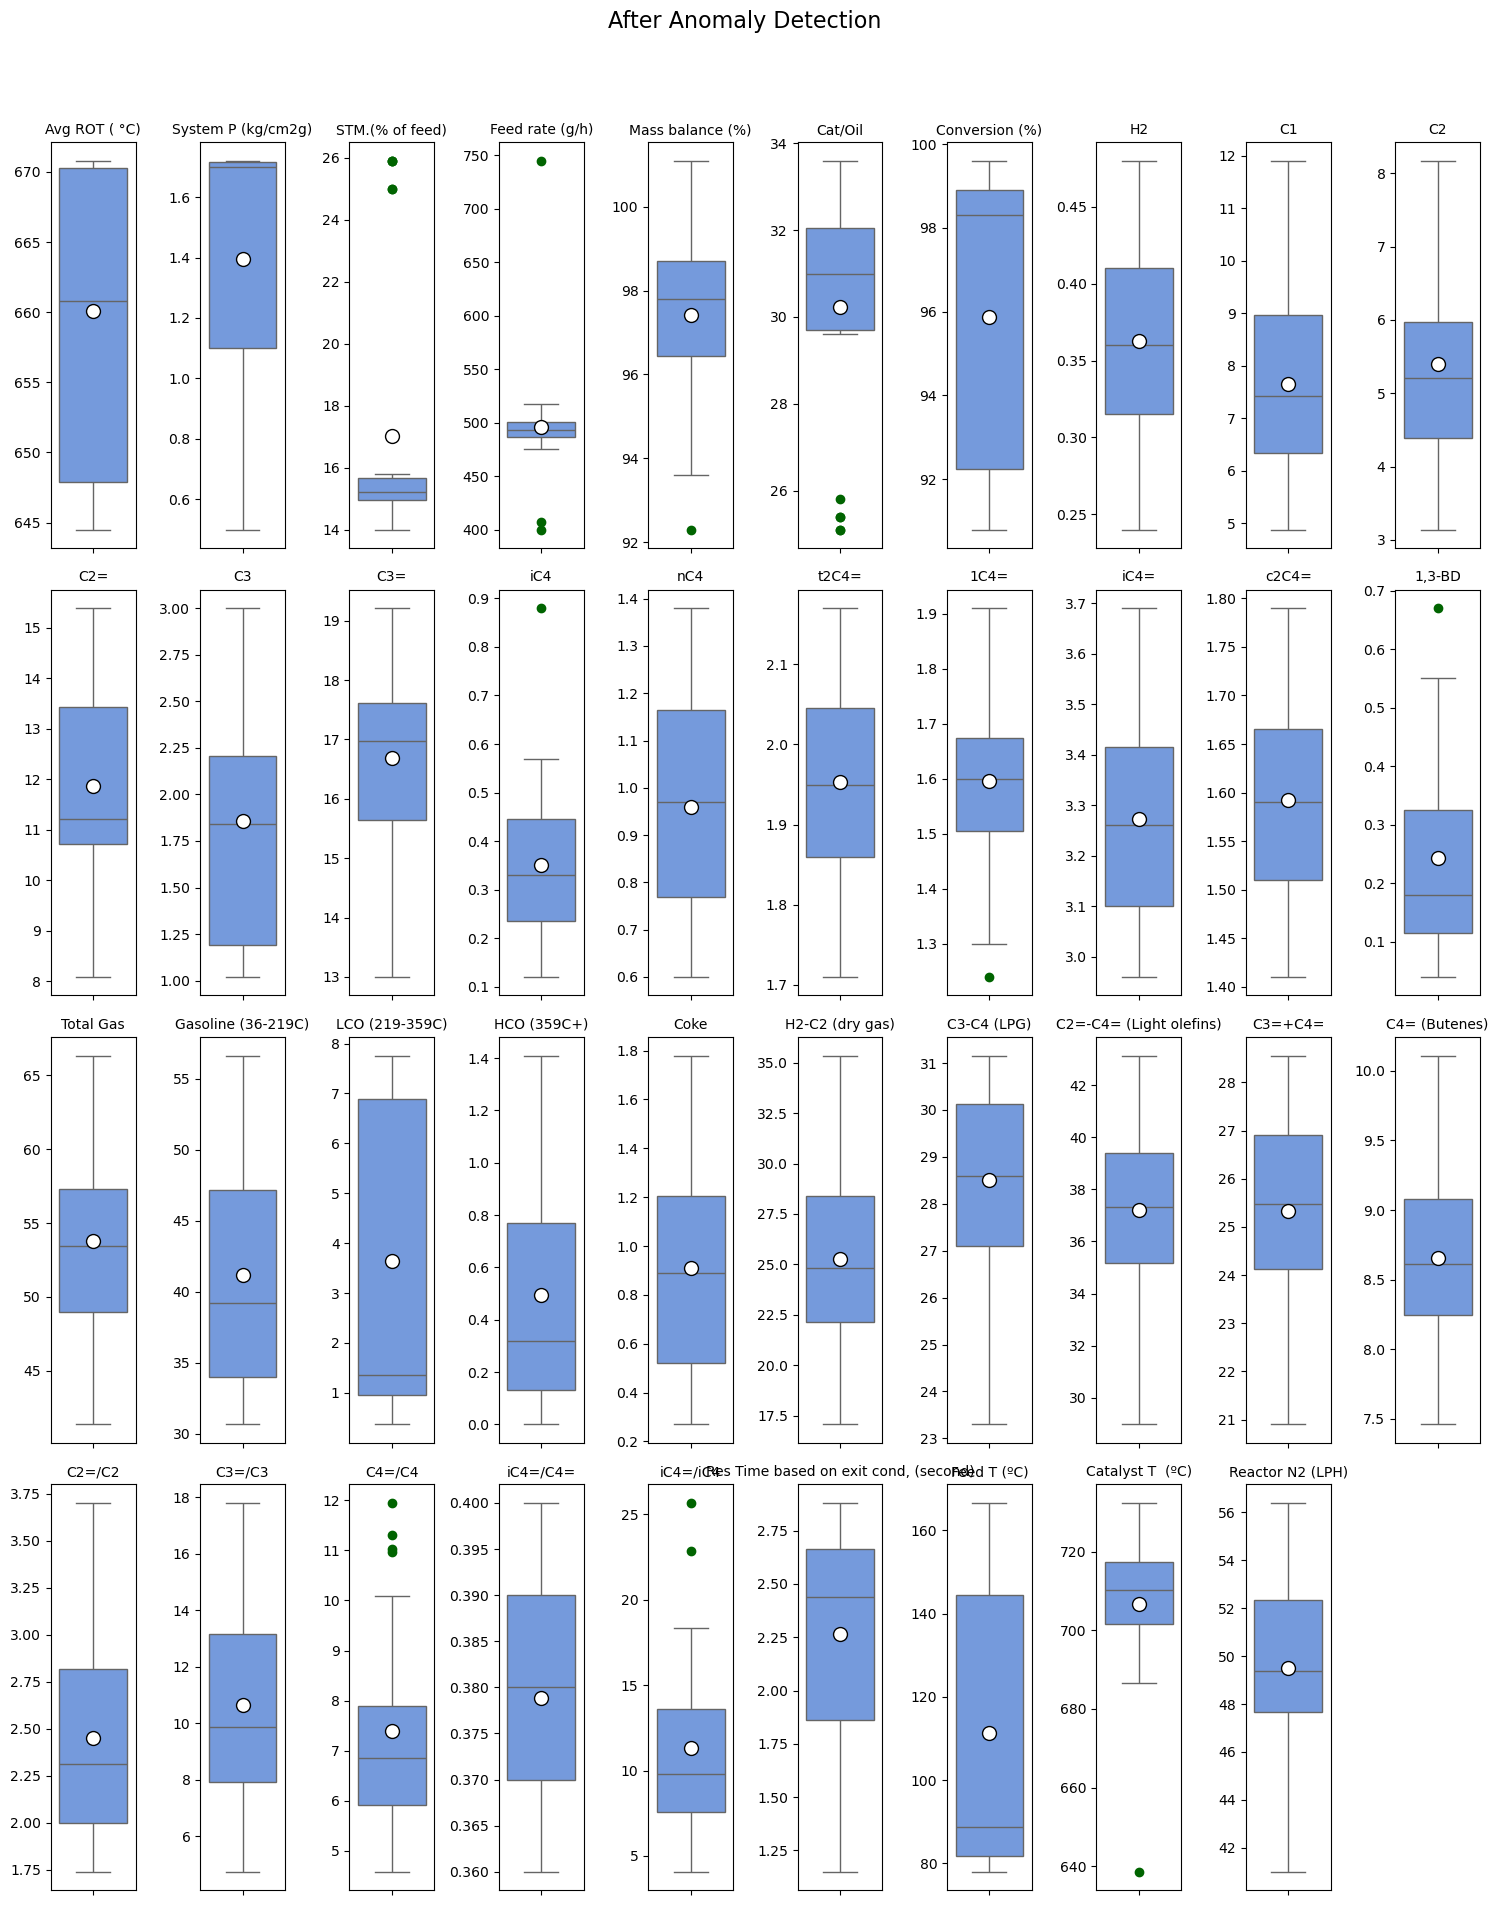

In [18]:
#Check the new columns which shows the anomaly
inputs = list(data_filtered.columns)
print(inputs)
# After anomaly detection
make_combined_boxplot(data_filtered, inputs, title="After Anomaly Detection", filename="boxplots_after.png")

In [19]:
#becuase my data is in different scales, it is better to scale using standard scaler.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_filtered)
#convert to dataframe
scaled_data = pd.DataFrame(scaled_data, columns=data_filtered.columns, index=data_filtered.index)

# understanding the correlations within my dataset

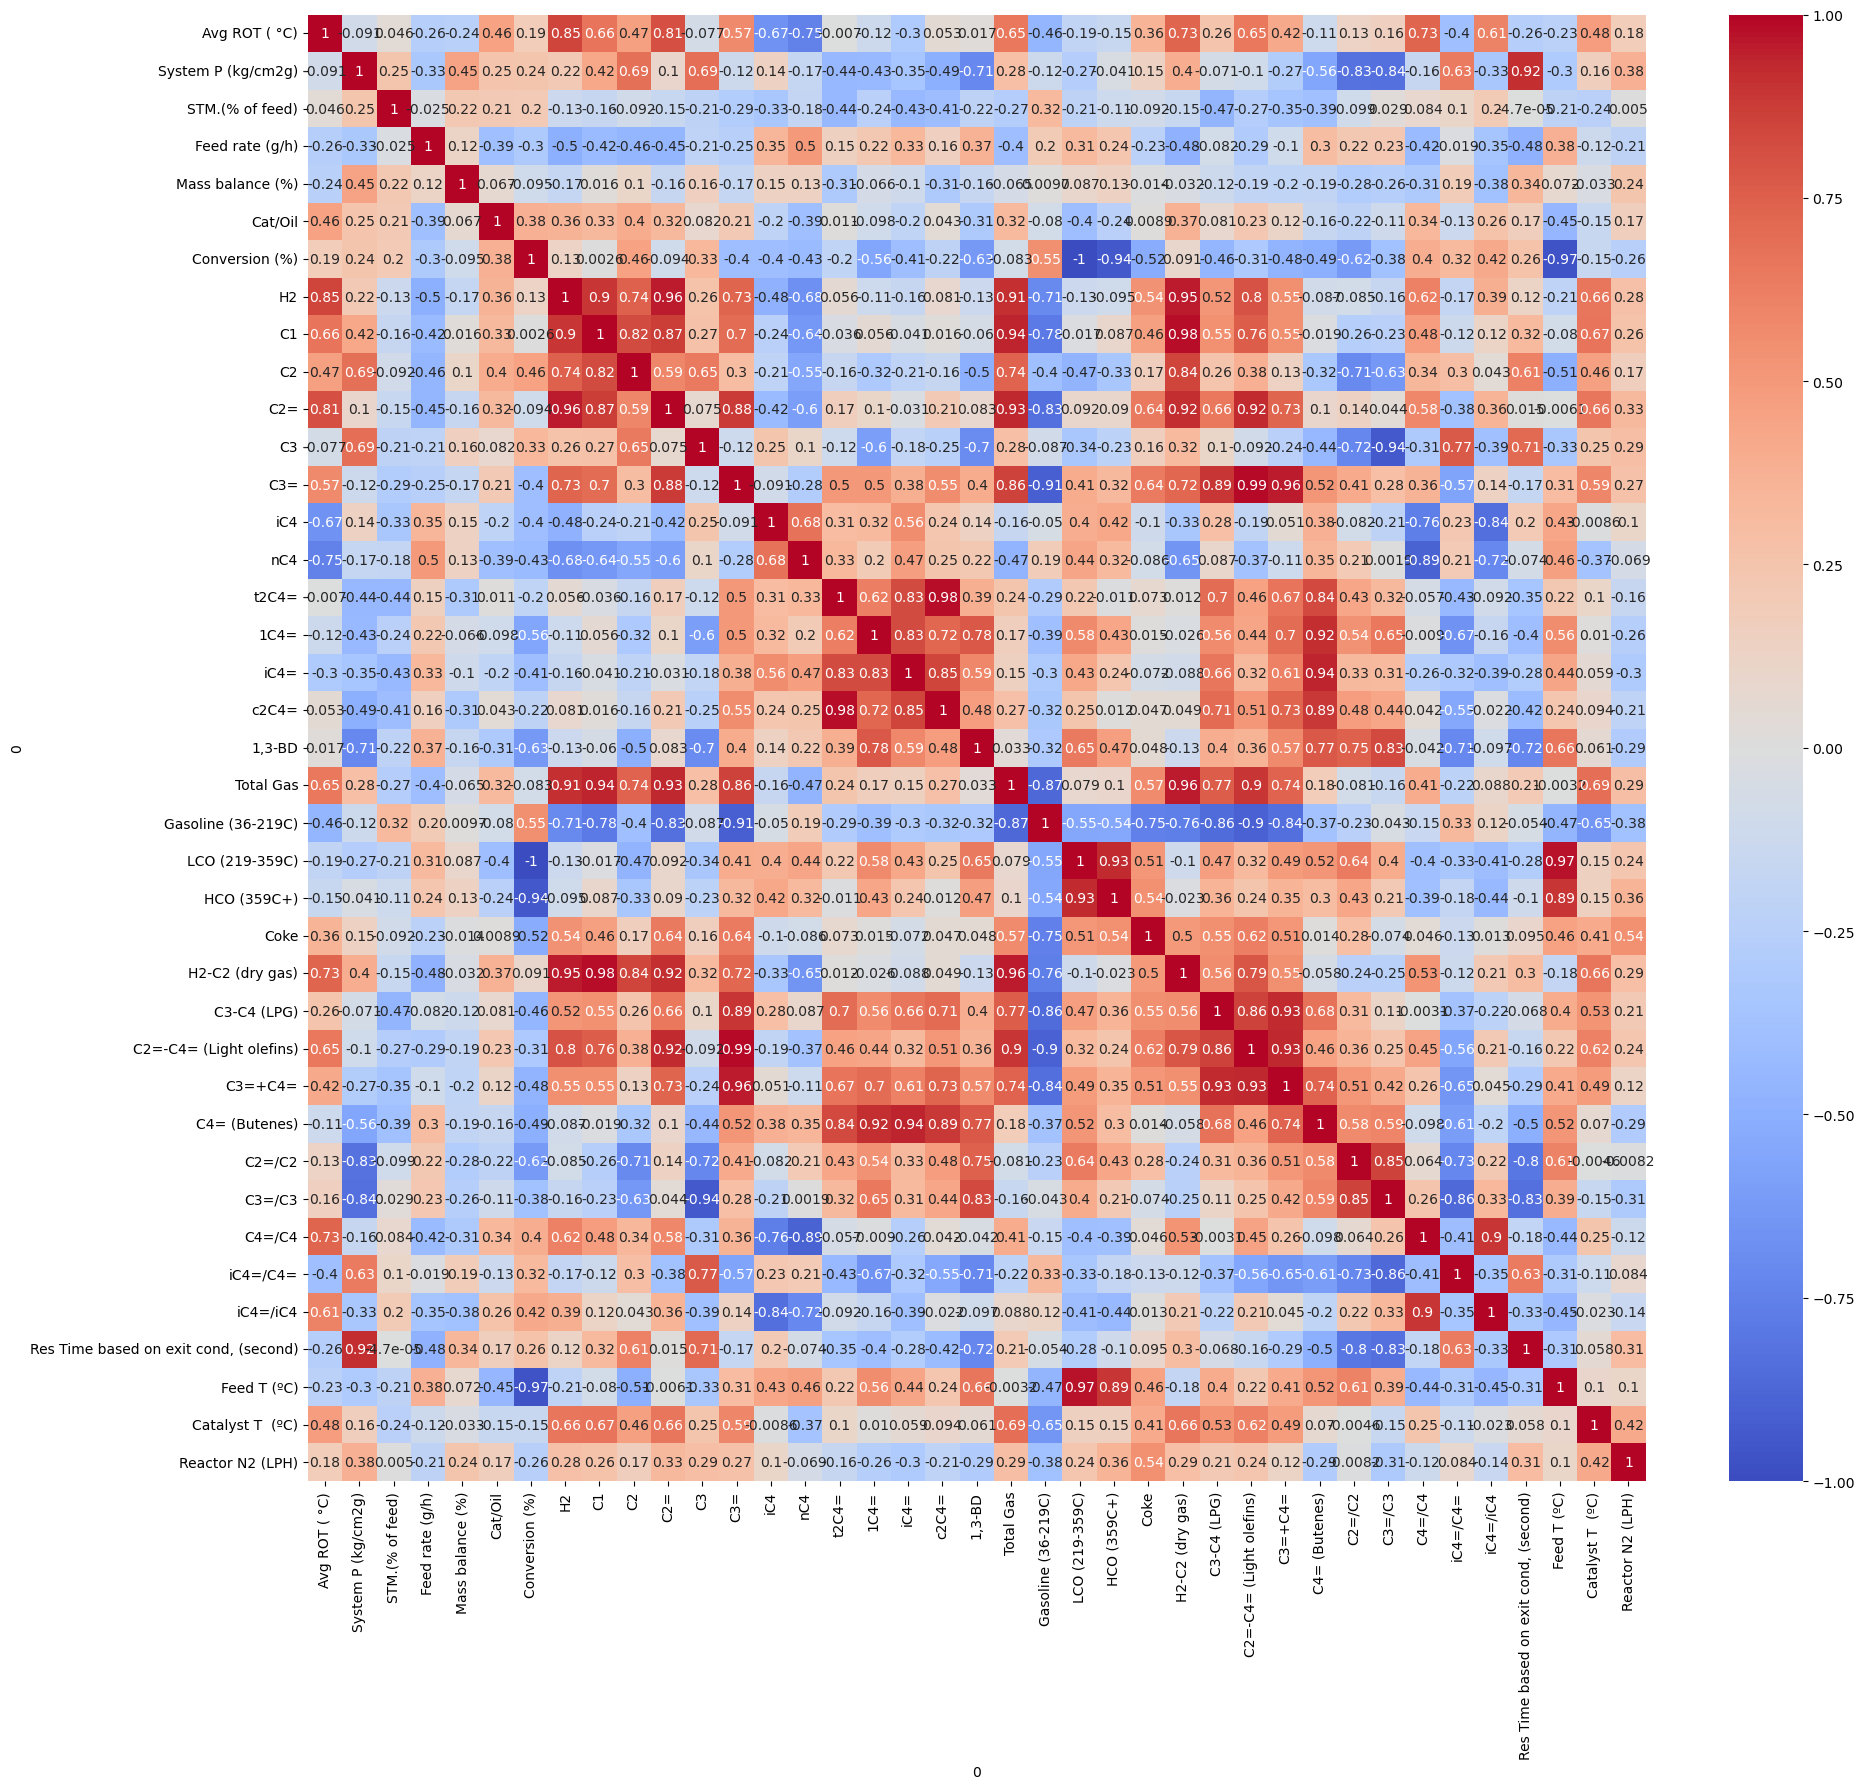

In [20]:
plt.figure(figsize=(20, 18))  # Adjust as needed
sns.heatmap(scaled_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)  # Save before showing
plt.show()

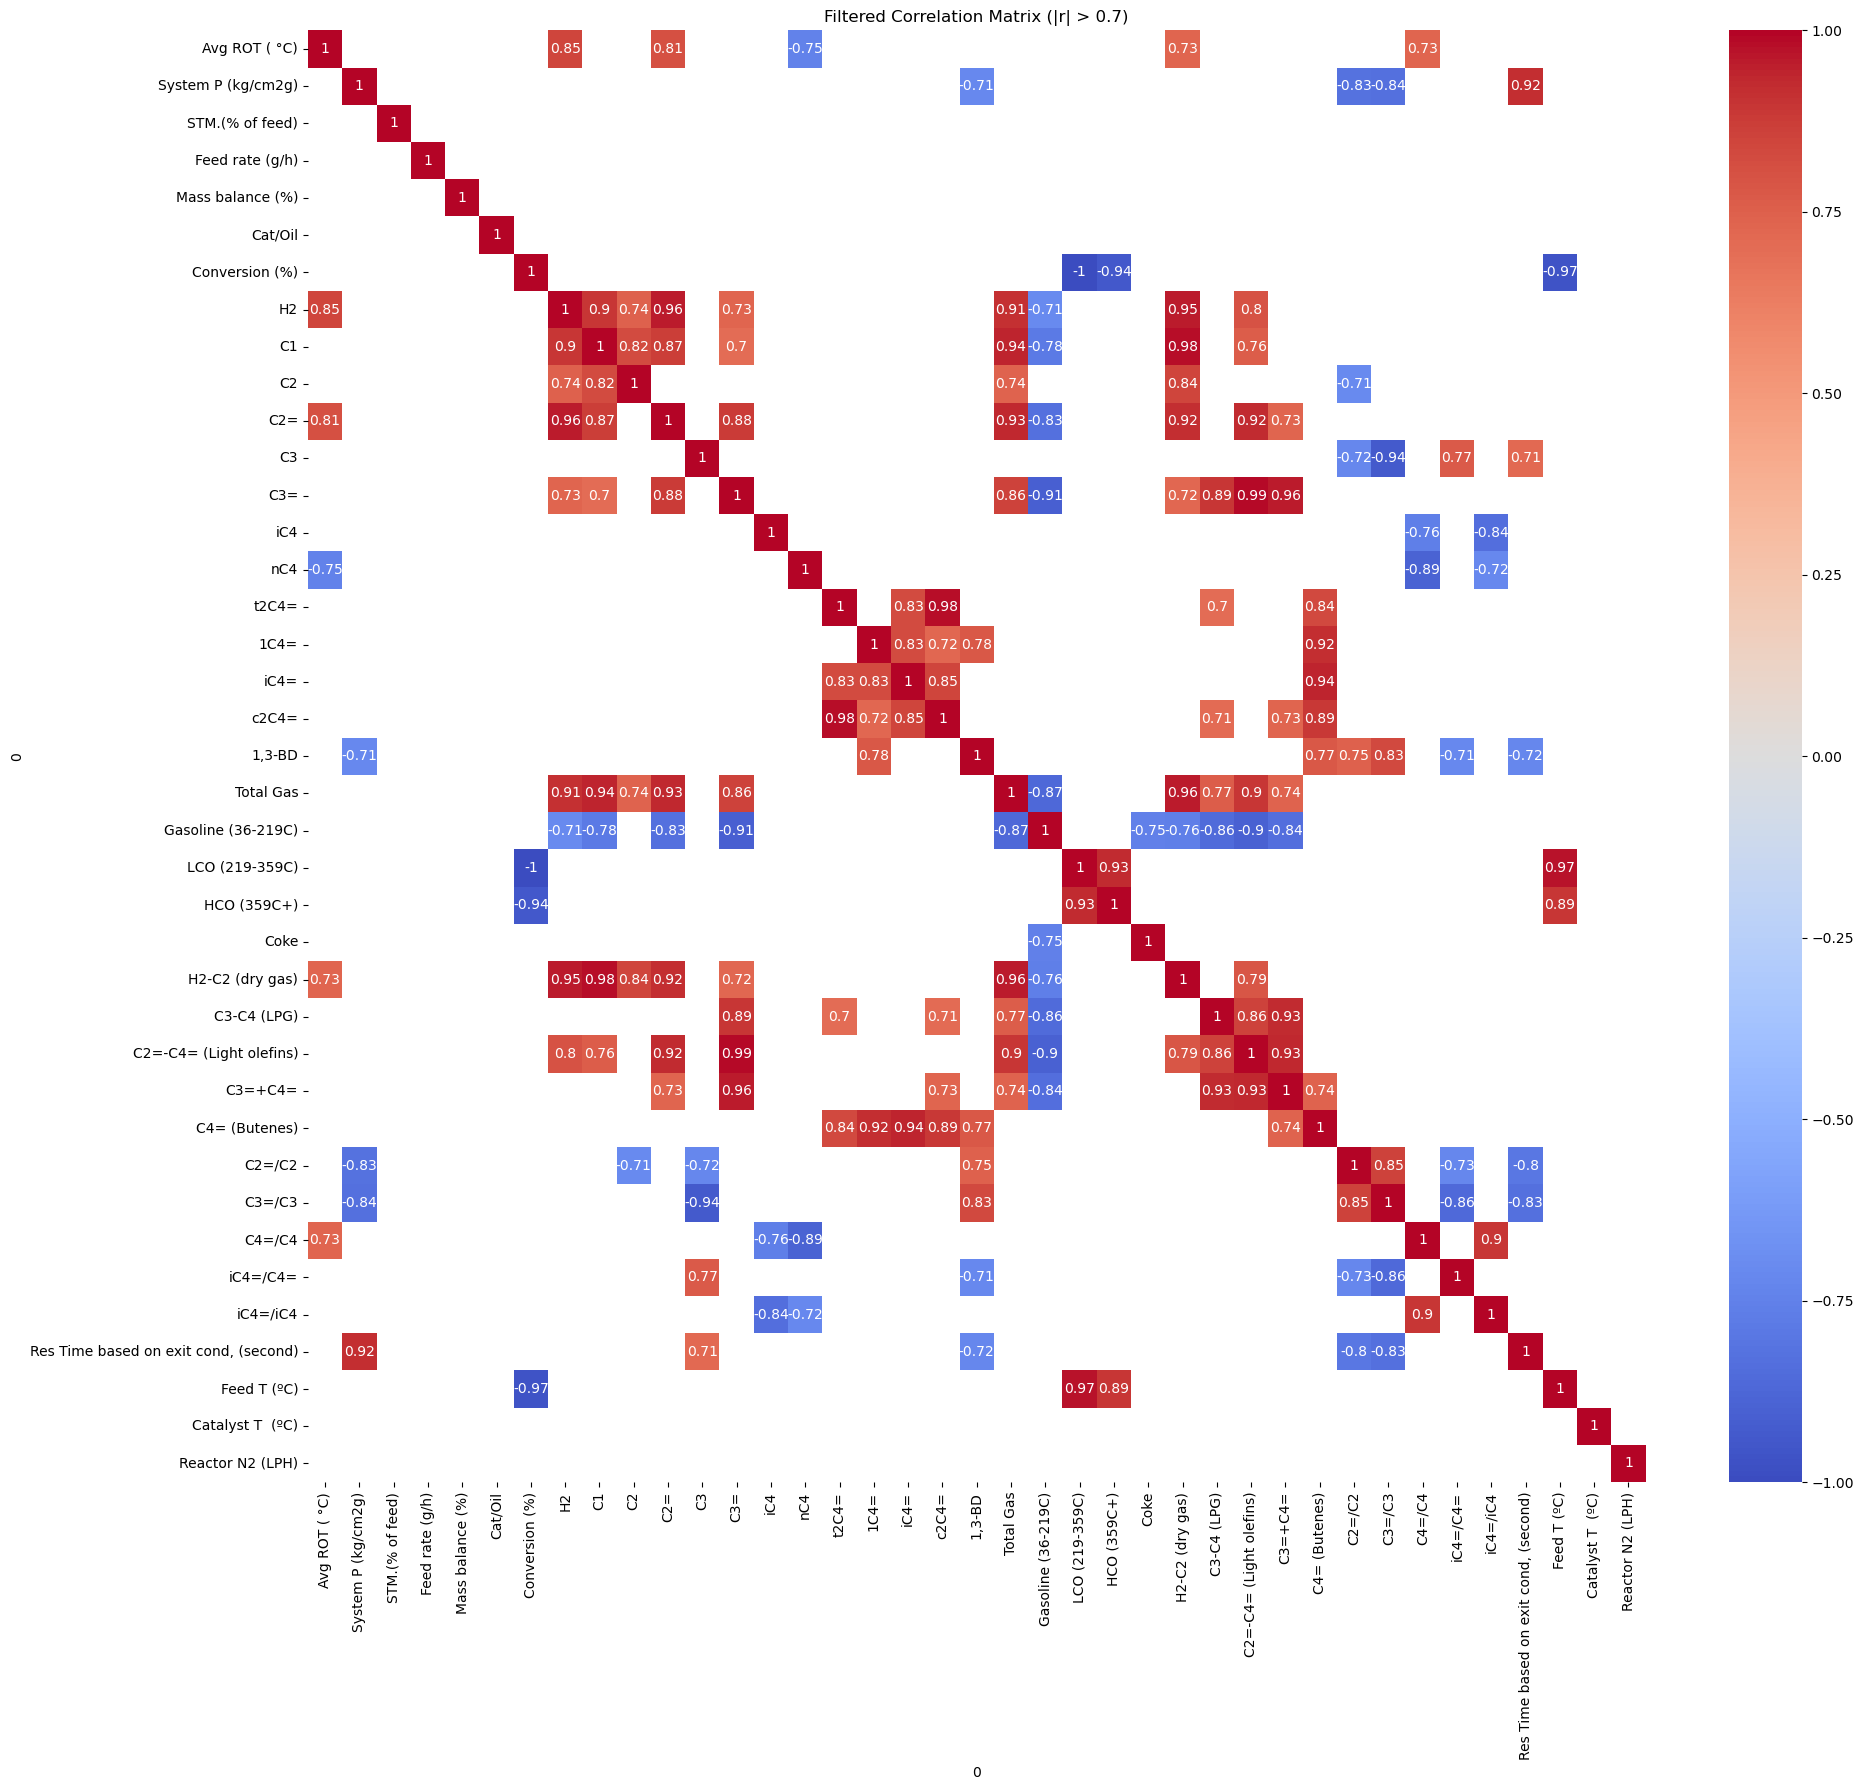

In [21]:
# Show only correlations > 0.7 or < -0.7
corr_matrix = scaled_data.corr()
mask = (corr_matrix >= 0.7) | (corr_matrix <= -0.7)
filtered_corr = corr_matrix.where(mask)

plt.figure(figsize=(20, 18))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Filtered Correlation Matrix (|r| > 0.7)")
plt.tight_layout()
plt.savefig("filtered_correlation_heatmap.png", dpi=300)
plt.show()

In [22]:
scaled_feat = scaled_data.drop(columns = [ 'Conversion (%)', 'Gasoline (36-219C)'])
feat_cols = data_filtered.drop(columns =['Conversion (%)', 'Gasoline (36-219C)'])

# Filtering the features to reduce co-linearity & bias

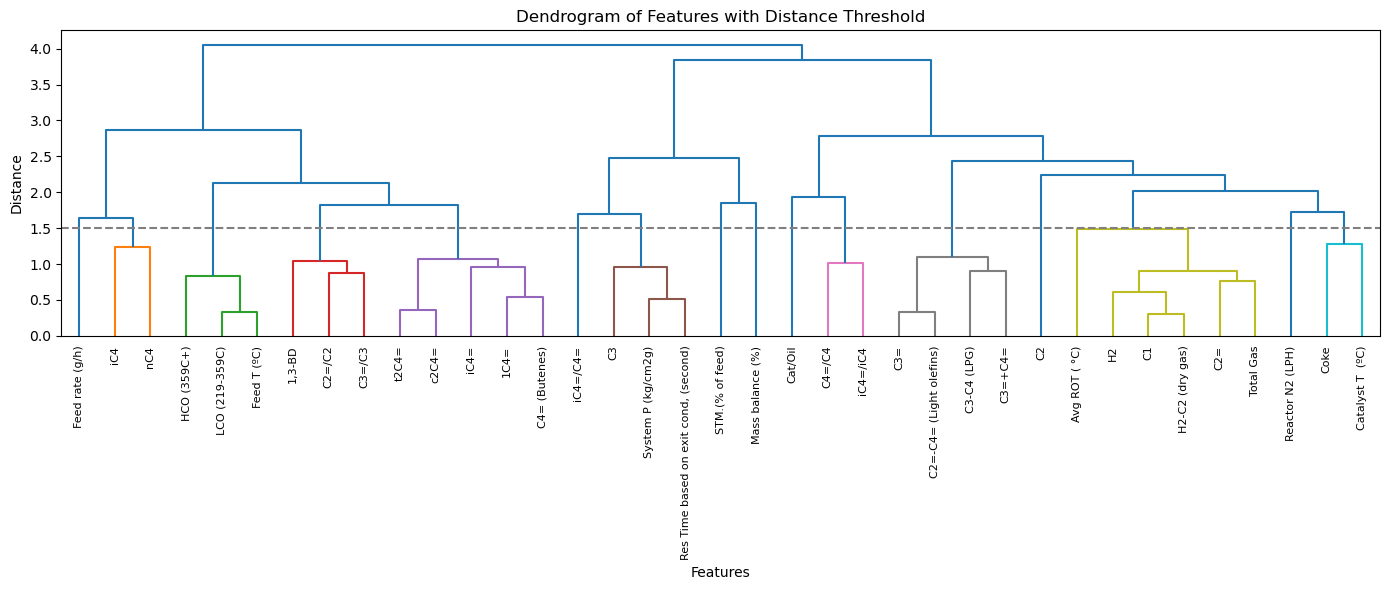

In [23]:
# Compute the correlation matrix and convert to a distance matrix
corr = scaled_feat.corr()
distance_matrix = 1 - corr

# Compute linkage for hierarchical clustering
linkage_matrix = linkage(pdist(distance_matrix), method='average')

# Set the threshold (adjust based on your data scale)
threshold = 1.5

# Plot the dendrogram with color threshold
plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    labels=scaled_feat.columns,
    orientation='top',
    leaf_rotation=90,
    color_threshold=threshold  # <-- controls color separation
)
plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1.5)
plt.title('Dendrogram of Features with Distance Threshold')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig("dendrogram.png", dpi=300)  # Save the dendrogram plot
plt.show()

In [24]:
scaled_data.columns

Index(['Avg ROT ( °C)', 'System P (kg/cm2g)', 'STM.(% of feed)',
       'Feed rate (g/h)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)',
       'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=',
       'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline (36-219C)',
       'LCO (219-359C)', 'HCO (359C+)', 'Coke', 'H2-C2 (dry gas)',
       'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)',
       'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4',
       'Res Time based on exit cond, (second)', 'Feed T (ºC)',
       'Catalyst T  (ºC)', 'Reactor N2 (LPH)'],
      dtype='object', name=0)

# Running PCA and clustering: understanding the hidden patterns

In [25]:
selected_data = scaled_data[['Mass balance (%)', 'C3', 'STM.(% of feed)', 'Feed rate (g/h)', 'nC4',
       'LCO (219-359C)', 'iC4=', 'C2=/C2', 'C3=', 'Total Gas', 'Coke',
       'C4=/C4', 'Conversion (%)', 'Gasoline (36-219C)']].copy()
selected_feat = selected_data.drop(columns = ['Conversion (%)', 'Gasoline (36-219C)'])

In [26]:
# Apply PCA on scaled data
pca = PCA()
pca_data = pca.fit_transform(selected_feat)
pca.explained_variance_ratio_.cumsum()

array([0.27367811, 0.53660346, 0.70096155, 0.81214751, 0.88313623,
       0.92643172, 0.9682059 , 0.98439301, 0.99405387, 0.99729319,
       0.99946412, 1.        ])

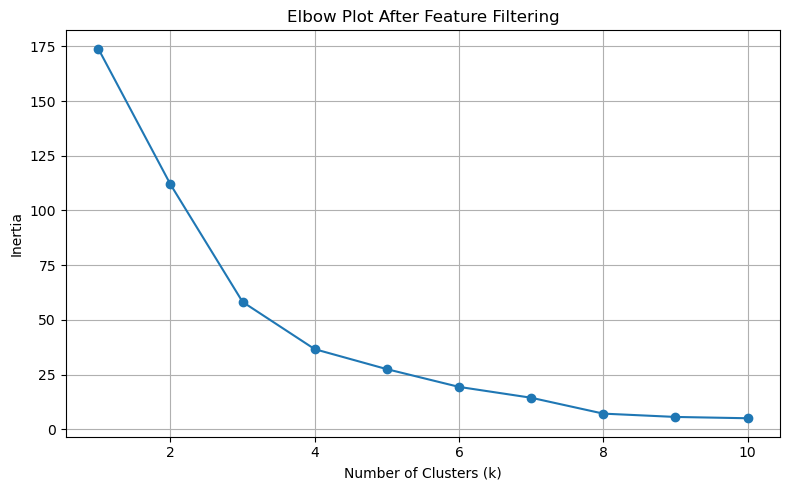

In [27]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data[:, :2])  # Use first 2 components
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot After Feature Filtering')  # Updated title
plt.grid(True)
plt.tight_layout()
plt.savefig("elbow_plot_after_feature_filtering.png", dpi=300)  # Save with updated name
plt.show()

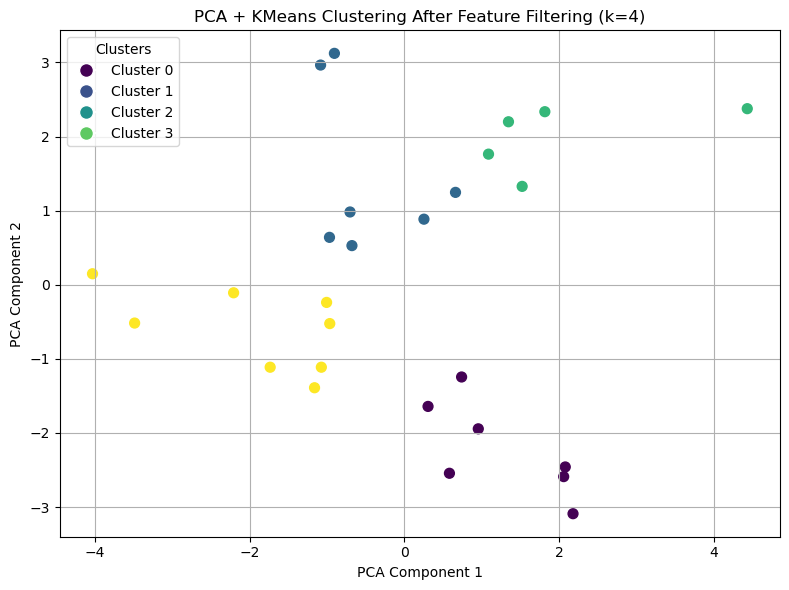

In [28]:
# Choose optimal k based on elbow and silhouette
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans_final.fit_predict(pca_data[:, :2])

# Plot the clusters
plt.figure(figsize=(8, 6))

# Scatter plot with one color per cluster
scatter = plt.scatter(
    pca_data[:, 0], pca_data[:, 1],
    c=final_labels, cmap='viridis', s=50
)

# Add legend with unique cluster labels
handles = []
for i in range(optimal_k):
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              label=f'Cluster {i}',
                              markerfacecolor=plt.cm.viridis(i / optimal_k),
                              markersize=10))

plt.legend(handles=handles, title='Clusters')
plt.title('PCA + KMeans Clustering After Feature Filtering (k=4)')  # Updated title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()

# Save the plot with the new title
plt.savefig("pca_kmeans_clustering_after_feature_filtering.png", dpi=300)
plt.show()

In [29]:
# Step 1: Create a DataFrame from final_labels (cluster assignments)
labels_df = pd.DataFrame(final_labels, index=data_filtered.index, columns=['Cluster'])

# Step 2: Concatenate tags, cleaned original data, and cluster labels
combined_df = pd.concat([tags, data_filtered, labels_df], axis=1).dropna()

Cluster                  0.0  1.0  2.0  3.0
Catalyst Feed                              
CAT-A    Gas Condensate    0    2    4    0
         Naphtha           3    0    0    1
CAT-B    Gas Condensate    0    5    1    0
         Naphtha           4    0    0    7

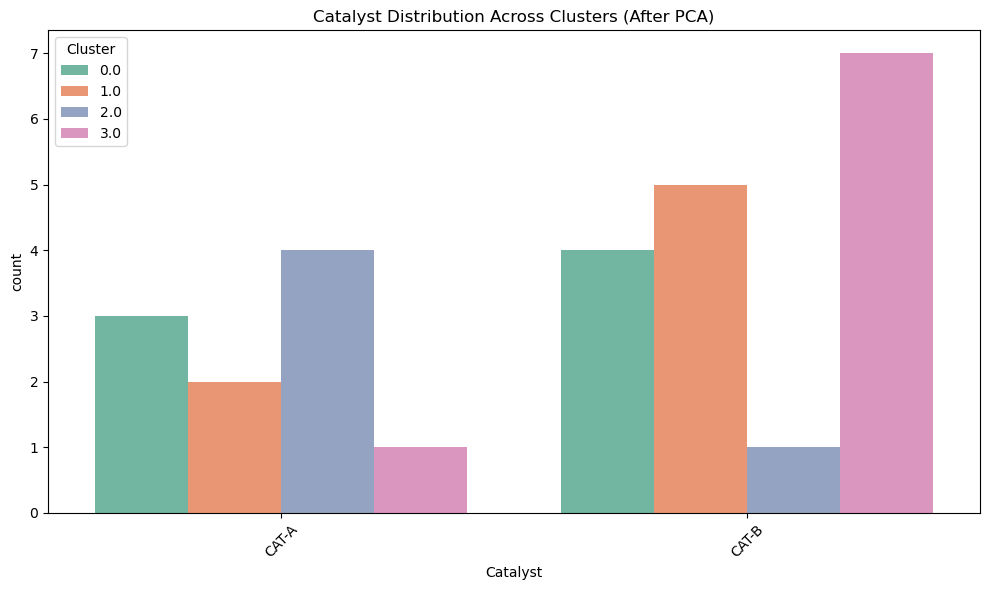

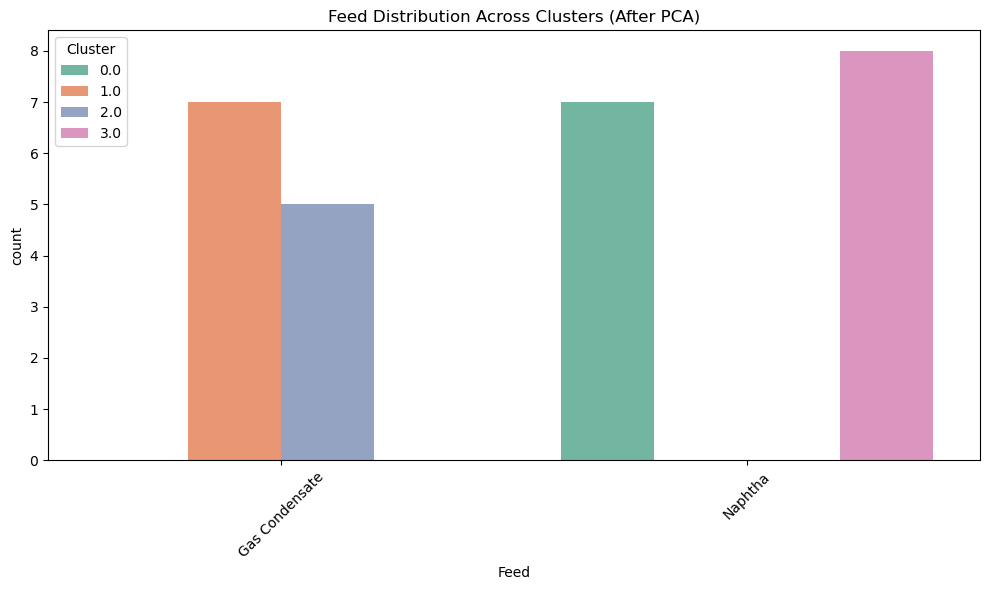

In [30]:
# 1. Crosstab for Catalyst and Feed vs Cluster
crosstab = pd.crosstab([combined_df['Catalyst'], combined_df['Feed']], combined_df['Cluster'])
display(crosstab)

# 2. Countplots for Catalyst vs Cluster and Feed vs Cluster after feature filtering
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='Catalyst', hue='Cluster', dodge=True, palette='Set2')
plt.title('Catalyst Distribution Across Clusters (After PCA)')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the first plot
plt.savefig("catalyst_distribution_across_clusters_after_PCA.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='Feed', hue='Cluster', dodge=True, palette='Set2')
plt.title('Feed Distribution Across Clusters (After PCA)')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the second plot
plt.savefig("feed_distribution_across_clusters_after_pca.png", dpi=300)
plt.show()

This is important because now I can use separate models depending on the feed since they cluster separately.

# defining the functions for storing and plotting results

In [31]:
# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "Dataset", "Feed_Type", "test_size", 
                                   "MAE_Train", "RMSE_Train", "R2_Train", "R_Train",
                                   "MAE_Test", "RMSE_Test", "R2_Test", "R_Test"])

# Function to evaluate and store model performance
def evaluate_and_store_results(model_name, dataset_name, feed_type, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)
    r_train, _ = pearsonr(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)
    r_test, _ = pearsonr(y_test, y_test_pred)

    # Calculate and round test set percentage
    test_percentage = round(len(y_test) / (len(y_train) + len(y_test)) * 100, 1)

    # Append results to DataFrame
    global results_df
    results_df = pd.concat([results_df, pd.DataFrame([{
        "Model": model_name,
        "Dataset": dataset_name,
        "Feed_Type": feed_type,
        "test_size": test_size,
        "MAE_Train": mae_train,
        "RMSE_Train": rmse_train,
        "R2_Train": r2_train,
        "R_Train": r_train,
        "MAE_Test": mae_test,
        "RMSE_Test": rmse_test,
        "R2_Test": r2_test,
        "R_Test": r_test
    }])], ignore_index=True)

In [32]:
# === Helper function: Plot Actual vs Predicted with Best-Fit Line ===
def plot_actual_vs_predicted(y_train, y_test, y_pred, title, xlabel, ylabel, model_name):
    y_actual = np.concatenate([y_train, y_test])
    y_actual = np.array(y_actual).flatten()
    y_pred = np.array(y_pred).flatten()

    sorted_indices = np.argsort(y_actual)
    y_actual_sorted = y_actual[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    reg = LinearRegression()
    reg.fit(y_actual_sorted.reshape(-1, 1), y_pred_sorted)
    y_fit = reg.predict(y_actual_sorted.reshape(-1, 1))

    return y_actual, y_pred, y_actual_sorted, y_fit

# === Main plotting function with saving ===
def plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, model_name, test_size):
    test_percentage = round(test_size * 100, 1)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Conversion Prediction
    y1_combined = np.concatenate([y1_train, y1_test])
    split_idx1 = len(y1_train)
    axs[0, 0].plot(y1_combined, label='Actual Conversion', color='blue', linestyle='--', marker='o')
    axs[0, 0].plot(y1_pred, label='Predicted Conversion', color='red', linestyle='-', marker='x')
    axs[0, 0].axvline(x=split_idx1, color='black', linestyle='--')
    ymin, ymax = axs[0, 0].get_ylim()
    y_mid = ymin + (ymax - ymin) * 0.5
    axs[0, 0].text(split_idx1 / 2, y_mid, 'Training', ha='center', va='center', fontsize=10)
    axs[0, 0].text(split_idx1 + (len(y1_test) / 2), y_mid, 'Testing', ha='center', va='center', fontsize=10)
    axs[0, 0].set_title(f'Conversion Prediction USING {model_name}\nTest Size: {test_percentage}%')
    axs[0, 0].set_xlabel('Samples')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot 2: Yield Prediction
    y2_combined = np.concatenate([y2_train, y2_test])
    split_idx2 = len(y2_train)
    axs[0, 1].plot(y2_combined, label='Actual Yield', color='blue', linestyle='--', marker='o')
    axs[0, 1].plot(y2_pred, label='Predicted Yield', color='red', linestyle='-', marker='x')
    axs[0, 1].axvline(x=split_idx2, color='black', linestyle='--')
    ymin2, ymax2 = axs[0, 1].get_ylim()
    y_mid2 = ymin2 + (ymax2 - ymin2) * 0.5
    axs[0, 1].text(split_idx2 / 2, y_mid2, 'Training', ha='center', va='center', fontsize=10)
    axs[0, 1].text(split_idx2 + (len(y2_test) / 2), y_mid2, 'Testing', ha='center', va='center', fontsize=10)
    axs[0, 1].set_title(f'Gasoline Yield Prediction USING {model_name}\nTest Size: {test_percentage}%')
    axs[0, 1].set_xlabel('Samples')
    axs[0, 1].set_ylabel('Value')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot 3: Best-Fit for Conversion
    y1_actual, y1_pred_sorted, y1_actual_sorted, y1_fit = plot_actual_vs_predicted(
        y1_train, y1_test, y1_pred, '', '', '', model_name
    )
    axs[1, 0].scatter(y1_actual, y1_pred_sorted, color="blue", label="Predicted vs Actual")
    axs[1, 0].plot(y1_actual_sorted, y1_fit, color="red", linewidth=2, label="Best Fit Line")
    axs[1, 0].set_xlabel(f"Actual Conversion Values Using {model_name}")
    axs[1, 0].set_ylabel(f"Predicted Conversion Values Using {model_name}")
    axs[1, 0].set_title(f"Actual vs Predicted with Best Fit Line (Conversion)\nTest Size: {test_percentage}%")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot 4: Best-Fit for Naptha Yield
    y2_actual, y2_pred_sorted, y2_actual_sorted, y2_fit = plot_actual_vs_predicted(
        y2_train, y2_test, y2_pred, '', '', '', model_name
    )
    axs[1, 1].scatter(y2_actual, y2_pred_sorted, color="blue", label="Predicted vs Actual")
    axs[1, 1].plot(y2_actual_sorted, y2_fit, color="red", linewidth=2, label="Best Fit Line")
    axs[1, 1].set_xlabel(f"Actual Naptha Yield Values Using {model_name}")
    axs[1, 1].set_ylabel(f"Predicted Naptha Yield Values Using {model_name}")
    axs[1, 1].set_title(f"Actual vs Predicted with Best Fit Line (Gaso;ine Yield)\nTest Size: {test_percentage}%")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Save the figure
    filename = f"{model_name.replace(' ', '_').lower()}_results_{test_percentage}pct.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# trying the models on the full dataset first

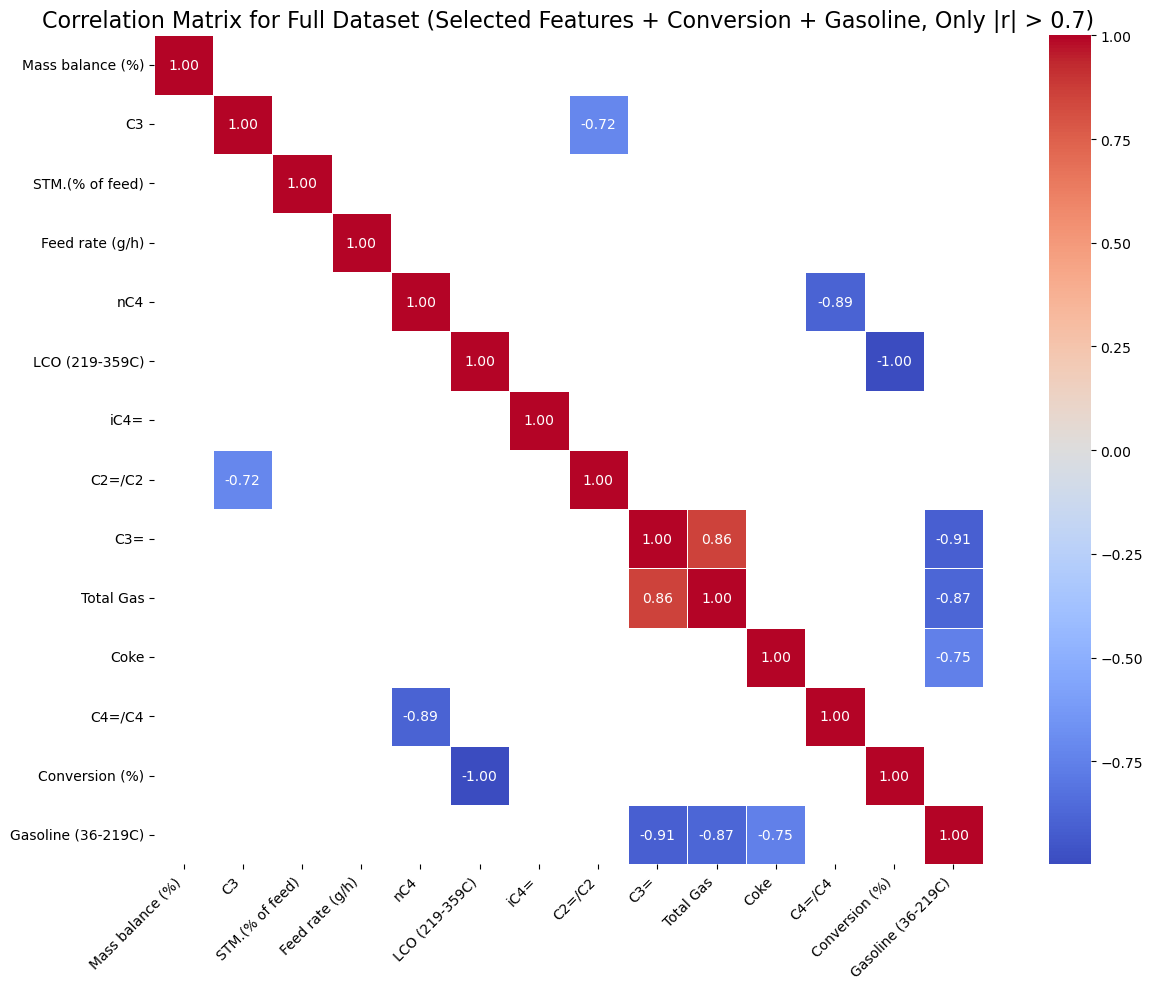

In [33]:
# 1. From the Full Dataset, select features from selected_feat + Conversion (%) + Gasoline (36-219C) (exclude Cluster)
features_to_use = selected_feat.columns.drop('Cluster', errors='ignore').tolist()
features_to_use += ['Conversion (%)', 'Gasoline (36-219C)']  # Add Conversion and Gasoline

# 2. Filter the Full Dataset to keep only these features
full_selected = combined_df[features_to_use]

# 3. Keep only numeric columns
full_selected_numeric = full_selected.select_dtypes(include=[np.number])

# 4. Calculate the correlation matrix
corr_matrix = full_selected_numeric.corr()

# 5. Mask correlations below the threshold (keep only |r| > 0.7)
threshold = 0.7
filtered_corr = corr_matrix.copy()
filtered_corr[(np.abs(filtered_corr) < threshold)] = np.nan

# 6. Plot
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, mask=filtered_corr.isnull())
plt.title(f"Correlation Matrix for Full Dataset (Selected Features + Conversion + Gasoline, Only |r| > {threshold})", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
# Full dataset before any separation
full_X_conversion = combined_df['LCO (219-359C)']
full_y_conversion = combined_df['Conversion (%)']
full_X_gasoline = combined_df[['C3=', 'Total Gas', 'Coke']]
full_y_gasoline = combined_df['Gasoline (36-219C)']

# **GPR-BO for the whole dataset**

In [35]:
# === Settings ===
test_sizes = [0.3]

# Bayesian Optimization Search Space
space = [
    Real(1e-3, 10, name="length_scale"),
    Real(1e-4, 1.0, name="sigma")
]

# Initialize the full results DataFrame
all_results_full = pd.DataFrame()

# === Start Loop ===
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Full Data
    X1_GPR, y1_GPR = full_X_conversion.to_frame(), full_y_conversion
    X2_GPR, y2_GPR = full_X_gasoline, full_y_gasoline

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_GPR, y1_GPR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_GPR, y2_GPR, test_size=test_size, random_state=42, shuffle=False)

    # Define Objective Functions
    @use_named_args(space)
    def objective1(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X1_train, y1_train)
        y_pred = gpr.predict(X1_test)
        return mean_squared_error(y1_test, y_pred)

    @use_named_args(space)
    def objective2(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X2_train, y2_train)
        y_pred = gpr.predict(X2_test)
        return mean_squared_error(y2_test, y_pred)

    # Run Bayesian Optimization
    print(" Optimizing GPR for Conversion...")
    result1 = gp_minimize(objective1, space, n_calls=20, random_state=42)
    best_length_scale1, best_sigma1 = result1.x
    print(f"Best Conversion Parameters: length_scale={best_length_scale1}, sigma={best_sigma1}")

    print("\n Optimizing GPR for Yield...")
    result2 = gp_minimize(objective2, space, n_calls=20, random_state=42)
    best_length_scale2, best_sigma2 = result2.x
    print(f"Best Yield Parameters: length_scale={best_length_scale2}, sigma={best_sigma2}")

    # Train Final GPR Models
    kernel1 = C(1.0) * RBF(length_scale=best_length_scale1) + WhiteKernel(noise_level=best_sigma1)
    gpr1 = GaussianProcessRegressor(kernel=kernel1, alpha=best_sigma1, n_restarts_optimizer=10)
    gpr1.fit(X1_train, y1_train)

    kernel2 = C(1.0) * RBF(length_scale=best_length_scale2) + WhiteKernel(noise_level=best_sigma2)
    gpr2 = GaussianProcessRegressor(kernel=kernel2, alpha=best_sigma2, n_restarts_optimizer=10)
    gpr2.fit(X2_train, y2_train)

    # Predict for plotting
    y1_GPR_pred = np.concatenate([gpr1.predict(X1_train), gpr1.predict(X1_test)])
    y2_GPR_pred = np.concatenate([gpr2.predict(X2_train), gpr2.predict(X2_test)])

    # Save results correctly
    previous_length = len(results_df)
    evaluate_and_store_results(f"GPR-BO Full (Test Size {test_size})", "Conversion", 'All Data', gpr1, X1_train, y1_train, X1_test, y1_test)
    new_row = results_df.iloc[[previous_length]]
    all_results_full = pd.concat([all_results_full, new_row], ignore_index=True)

    previous_length = len(results_df)
    evaluate_and_store_results(f"GPR-BO Full (Test Size {test_size})", "Yield", 'All Data', gpr2, X2_train, y2_train, X2_test, y2_test)
    new_row = results_df.iloc[[previous_length]]
    all_results_full = pd.concat([all_results_full, new_row], ignore_index=True)

    # Plot (assuming you defined this function elsewhere)
    plot_subplots(y1_train, y1_test, y1_GPR_pred, y2_train, y2_test, y2_GPR_pred, f"GPR-BO Full (Test Size {test_size})", test_size=test_size)

# Done
print("\n📊 All Model Results Across All Test Sizes (Full Dataset):")
print(all_results_full)


================= Test Size: 30% =================
 Optimizing GPR for Conversion...
Best Conversion Parameters: length_scale=6.757937167659344, sigma=0.999892677438379

 Optimizing GPR for Yield...
Best Yield Parameters: length_scale=6.1169199517223225, sigma=0.007165598589195436

📊 All Model Results Across All Test Sizes (Full Dataset):
                         Model     Dataset Feed_Type  test_size  MAE_Train  \
0  GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.115537   
1  GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   1.864964   

   RMSE_Train  R2_Train   R_Train  MAE_Test  RMSE_Test   R2_Test    R_Test  
0    0.154650  0.997612  0.998821  0.147688   0.194361  0.996591  0.998349  
1    2.334961  0.901473  0.949714  2.808328   3.165922  0.053230  0.675466  


# BT-BO for the whole dataset

In [36]:
# === Settings ===
test_sizes = [0.3]

# Define Bayesian Optimization Search Space
space = [
    Integer(50, 500, name="n_estimators"),
    Integer(2, 10, name="max_depth"),
    Real(0.01, 0.3, name="learning_rate"),
    Real(0.1, 1.0, name="subsample")
]

# Initialize an empty dataframe for all results
all_results_btbo_full = pd.DataFrame()

# === Function to run Bayesian Optimization
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, objective_func, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    # Run Bayesian Optimization
    result = gp_minimize(objective_func, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train final model with optimized hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=best_params[0],
        max_depth=best_params[1],
        learning_rate=best_params[2],
        subsample=best_params[3],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = np.concatenate([y_train_pred, y_test_pred])  # Combined predictions

    return model, y_pred

# === Start looping through different test_sizes
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Full Dataset
    X1_BT, y1_BT = full_X_conversion.to_frame(), full_y_conversion
    X2_BT, y2_BT = full_X_gasoline, full_y_gasoline

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_BT, y1_BT, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_BT, y2_BT, test_size=test_size, random_state=42, shuffle=False)

    # === Define Objective Functions inside loop
    @use_named_args(space)
    def objective1(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X1_train, y1_train)
        y1_pred = model.predict(X1_test)
        return mean_squared_error(y1_test, y1_pred)

    @use_named_args(space)
    def objective2(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X2_train, y2_train)
        y2_pred = model.predict(X2_test)
        return mean_squared_error(y2_test, y2_pred)

    # === Run Optimization and Train Models
    model1, y1_pred = run_bayesian_optimization(f"BT-BO Full (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, objective1, "Conversion", 'All Data')
    model2, y2_pred = run_bayesian_optimization(f"BT-BO Full (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, objective2, "Yield", 'All Data')

    # === Save temporary results
    temp_results = pd.DataFrame()

    evaluate_and_store_results(f"BT-BO Full (Test Size {test_size})", "Conversion", 'All Data', model1, X1_train, y1_train, X1_test, y1_test)
    temp_results = pd.concat([temp_results, results_df], ignore_index=True)

    evaluate_and_store_results(f"BT-BO Full (Test Size {test_size})", "Yield", 'All Data', model2, X2_train, y2_train, X2_test, y2_test)
    temp_results = pd.concat([temp_results, results_df], ignore_index=True)

    # === Append results
    all_results_btbo_full = pd.concat([all_results_btbo_full, temp_results], ignore_index=True)
    results_df = pd.concat([results_df, temp_results], ignore_index=True)

    # === Plot
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"BT-BO Full (Test Size {test_size})", test_size=test_size)

# === After the loop
print("\n📊 All Model Results Across All Test Sizes (BT-BO Full Dataset):")
print(all_results_btbo_full)


================= Test Size: 30% =================
Optimizing BT-BO Full (Test Size 0.3) for Conversion
Best hyperparameters for BT-BO Full (Test Size 0.3): [105, 7, 0.026167953354844016, 0.7470201731668262]
Optimizing BT-BO Full (Test Size 0.3) for Yield
Best hyperparameters for BT-BO Full (Test Size 0.3): [85, 8, 0.3, 0.26372824033794917]

📊 All Model Results Across All Test Sizes (BT-BO Full Dataset):
                         Model     Dataset Feed_Type  test_size  MAE_Train  \
0  GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.115537   
1  GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   1.864964   
2   BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.180660   
3  GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.115537   
4  GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   1.864964   
5   BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.180660   
6   BT-BO Full (Test Size 0.3)       Yield  A

# RLR-BO on the whole dataset

In [37]:
# === Settings ===
test_sizes = [0.3]

# Define Bayesian Optimization Search Space for RLR
space = [
    Integer(50, 500, name="max_trials"),
    Real(1e-5, 0.1, name="min_samples")
]

# Initialize an empty dataframe for all results
all_results_rlrbo_full = pd.DataFrame()

# === Generalized Bayesian Optimization Function ===
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    @use_named_args(space)
    def objective(max_trials, min_samples):
        model = RANSACRegressor(
            max_trials=max_trials,
            min_samples=min_samples,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    # Run Bayesian Optimization
    result = gp_minimize(objective, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train Final Model
    model = RANSACRegressor(
        max_trials=best_params[0],
        min_samples=best_params[1],
        random_state=42
    )
    model.fit(X_train, y_train)

    return model

# === Start looping through different test_sizes ===
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Full Dataset
    X1_RLR, y1_RLR = full_X_conversion.to_frame(), full_y_conversion
    X2_RLR, y2_RLR = full_X_gasoline, full_y_gasoline

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_RLR, y1_RLR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_RLR, y2_RLR, test_size=test_size, random_state=42, shuffle=False)

    # === Run Bayesian Optimization and Train
    model1 = run_bayesian_optimization(f"RLR-BO Full (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, "Conversion", 'All Data')
    model2 = run_bayesian_optimization(f"RLR-BO Full (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, "Yield", 'All Data')

    # === Predict for plotting
    y1_train_pred = model1.predict(X1_train)
    y1_test_pred = model1.predict(X1_test)
    y1_pred = np.concatenate([y1_train_pred, y1_test_pred])

    y2_train_pred = model2.predict(X2_train)
    y2_test_pred = model2.predict(X2_test)
    y2_pred = np.concatenate([y2_train_pred, y2_test_pred])

    # === Save temporary results
    temp_results = pd.DataFrame()

    evaluate_and_store_results(f"RLR-BO Full (Test Size {test_size})", "Conversion", 'All Data', model1, X1_train, y1_train, X1_test, y1_test)
    temp_results = pd.concat([temp_results, results_df], ignore_index=True)

    evaluate_and_store_results(f"RLR-BO Full (Test Size {test_size})", "Yield", 'All Data', model2, X2_train, y2_train, X2_test, y2_test)
    temp_results = pd.concat([temp_results, results_df], ignore_index=True)

    # === Append results
    all_results_rlrbo_full = pd.concat([all_results_rlrbo_full, temp_results], ignore_index=True)
    results_df = pd.concat([results_df, temp_results], ignore_index=True)

    # === Plotting
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"RLR-BO Full (Test Size {test_size})", test_size=test_size)

# === After the loop
print("\n📊 All Model Results Across All Test Sizes (RLR-BO Full Dataset):")
print(all_results_rlrbo_full)


================= Test Size: 30% =================
Optimizing RLR-BO Full (Test Size 0.3) for Conversion
Best hyperparameters for RLR-BO Full (Test Size 0.3): [401, 0.05968904729306925]
Optimizing RLR-BO Full (Test Size 0.3) for Yield
Best hyperparameters for RLR-BO Full (Test Size 0.3): [408, 0.01835164463871772]

📊 All Model Results Across All Test Sizes (RLR-BO Full Dataset):
                          Model     Dataset Feed_Type  test_size  MAE_Train  \
0   GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.115537   
1   GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   1.864964   
2    BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.180660   
3    BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   0.293447   
4   GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   0.115537   
5   GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   1.864964   
6    BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3

In [38]:
results_df.to_csv('Statistical Comparison of the full data models.csv', index = False)

# Preparing the datasets with the broader separation: 
# KGC (clusters 1 &2) and LSRN (clusters 0&3)

In [39]:
#startinng with the broad separation
#Create KGC for Cluster labels 1 and 2
KGC = combined_df[combined_df['Cluster'].isin([1, 2])].copy()
# Create LSRN for Cluster labels 0 and 3
LSRN = combined_df[combined_df['Cluster'].isin([0, 3])].copy()

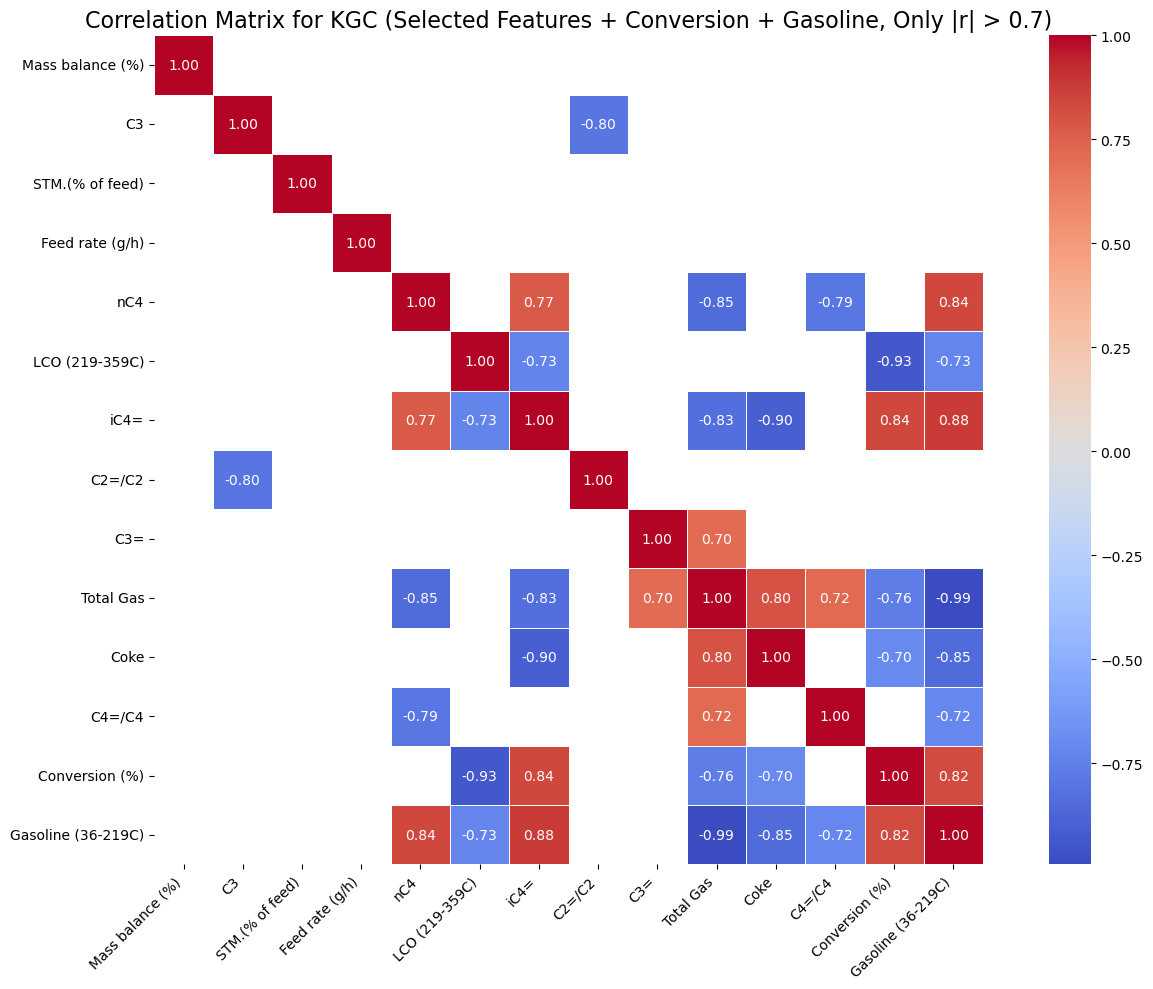

In [40]:
# 1. From KGC, select features from selected_feat + Conversion (%) + Gasoline (36-219C) (exclude Cluster)
features_to_use = selected_feat.columns.drop('Cluster', errors='ignore').tolist()
features_to_use += ['Conversion (%)', 'Gasoline (36-219C)']

# 2. Filter KGC to keep only these features
KGC_selected = KGC[features_to_use]

# 3. Keep only numeric columns
KGC_selected_numeric = KGC_selected.select_dtypes(include=[np.number])

# 4. Calculate correlation matrix
corr_matrix = KGC_selected_numeric.corr()

# 5. Mask correlations below threshold (keep > 0.7)
threshold = 0.7
filtered_corr = corr_matrix.copy()
filtered_corr[(np.abs(filtered_corr) < threshold)] = np.nan

# 6. Plot
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, mask=filtered_corr.isnull())
plt.title(f"Correlation Matrix for KGC (Selected Features + Conversion + Gasoline, Only |r| > {threshold})", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
#selected the highly correlated features (both positive or negative) with each target
KGC_conversion = KGC[['Conversion (%)','iC4=', 'LCO (219-359C)']]
KGC_gasoline = KGC[['Gasoline (36-219C)','iC4=', 'nC4', 'Total Gas', 'Coke']]

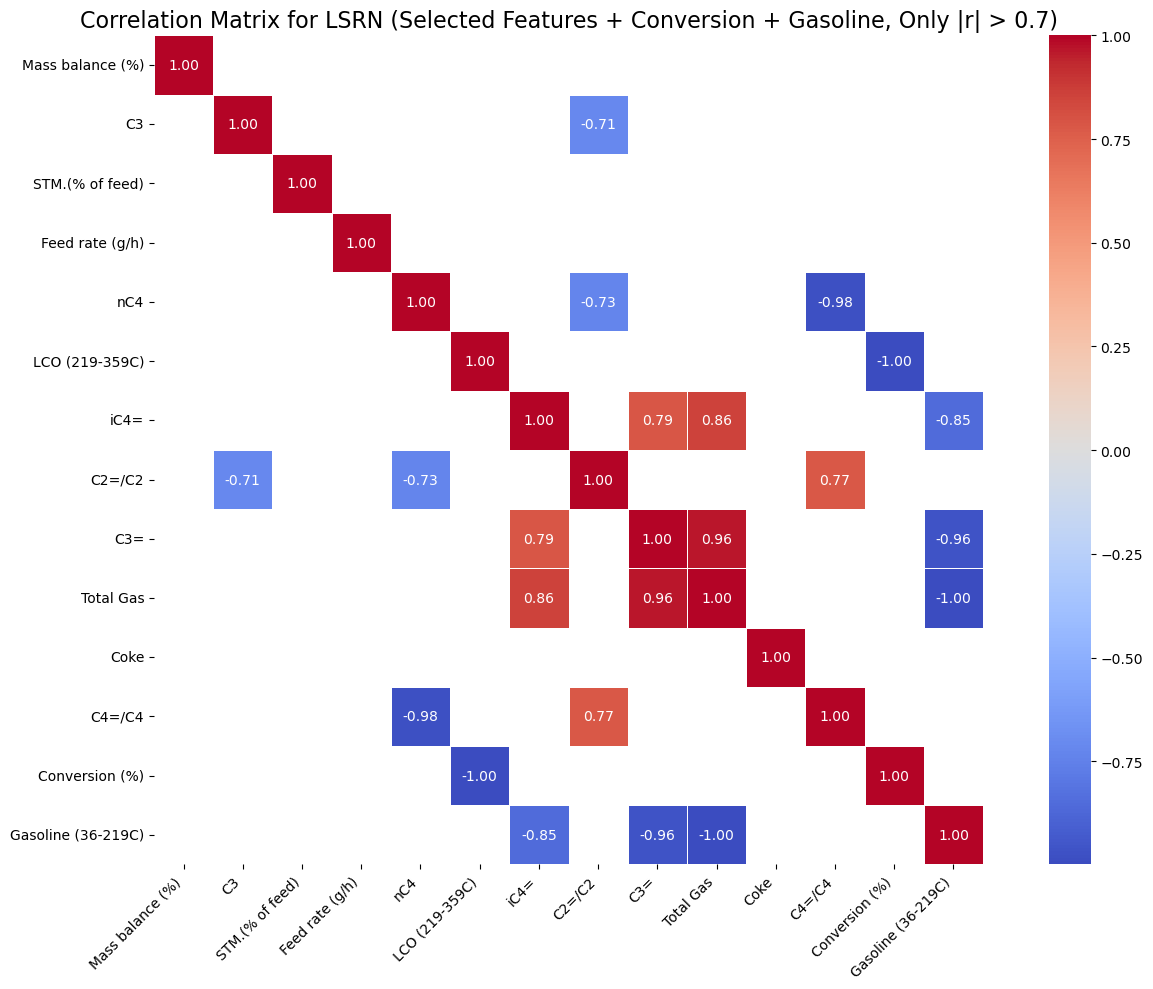

In [42]:
# 1. From LSRN, select features from selected_feat + Conversion (%) + Gasoline (36-219C)
features_to_use = selected_feat.columns.drop('Cluster', errors='ignore').tolist()
features_to_use += ['Conversion (%)', 'Gasoline (36-219C)']

# 2. Filter LSRN to keep only these features
LSRN_selected = LSRN[features_to_use]

# 3. Keep only numeric columns
LSRN_selected_numeric = LSRN_selected.select_dtypes(include=[np.number])

# 4. Calculate correlation matrix
corr_matrix = LSRN_selected_numeric.corr()

# 5. Mask correlations below threshold (keep > 0.7)
threshold = 0.7
filtered_corr = corr_matrix.copy()
filtered_corr[(np.abs(filtered_corr) < threshold)] = np.nan

# 6. Plot
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, mask=filtered_corr.isnull())
plt.title(f"Correlation Matrix for LSRN (Selected Features + Conversion + Gasoline, Only |r| > {threshold})", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
#selected the highly correlated features (both positive or negative) with each target
LSRN_conversion = LSRN[['Conversion (%)','LCO (219-359C)']]
LSRN_gasoline = LSRN[['Gasoline (36-219C)','C3=', 'Total Gas', 'iC4=']]

# **GPR-BO for KGC Feed**

In [44]:
# === Settings ===
test_sizes = [0.3]

# === Bayesian Optimization Search Space ===
space = [
    Real(1e-3, 10, name="length_scale"),
    Real(1e-4, 1.0, name="sigma")
]

# === Create an empty cumulative results table
all_results_gprbo_kgc = pd.DataFrame()

for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # === Prepare Data ===
    X1_GPR, y1_GPR = KGC_conversion.drop(columns=['Conversion (%)']), KGC_conversion['Conversion (%)']
    X2_GPR, y2_GPR = KGC_gasoline.drop(columns=['Gasoline (36-219C)']), KGC_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_GPR, y1_GPR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_GPR, y2_GPR, test_size=test_size, random_state=42, shuffle=False)

    # === Define Objective Functions
    @use_named_args(space)
    def objective1(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X1_train, y1_train)
        y_pred = gpr.predict(X1_test)
        return mean_squared_error(y1_test, y_pred)

    @use_named_args(space)
    def objective2(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X2_train, y2_train)
        y_pred = gpr.predict(X2_test)
        return mean_squared_error(y2_test, y_pred)

    # === Run Bayesian Optimization
    print(" Optimizing GPR for Conversion...")
    result1 = gp_minimize(objective1, space, n_calls=20, random_state=42)
    best_length_scale1, best_sigma1 = result1.x
    print(f" Best hyperparameters for Conversion: Length Scale = {best_length_scale1}, Sigma = {best_sigma1}")

    print("\n Optimizing GPR for Yield...")
    result2 = gp_minimize(objective2, space, n_calls=20, random_state=42)
    best_length_scale2, best_sigma2 = result2.x
    print(f" Best hyperparameters for Yield: Length Scale = {best_length_scale2}, Sigma = {best_sigma2}")

    # === Train Final GPR Models
    kernel1 = C(1.0) * RBF(length_scale=best_length_scale1) + WhiteKernel(noise_level=best_sigma1)
    gpr1 = GaussianProcessRegressor(kernel=kernel1, alpha=best_sigma1, n_restarts_optimizer=10)
    gpr1.fit(X1_train, y1_train)

    kernel2 = C(1.0) * RBF(length_scale=best_length_scale2) + WhiteKernel(noise_level=best_sigma2)
    gpr2 = GaussianProcessRegressor(kernel=kernel2, alpha=best_sigma2, n_restarts_optimizer=10)
    gpr2.fit(X2_train, y2_train)

    # === Predict All for Plotting
    y1_GPR_pred = np.concatenate([
        gpr1.predict(X1_train),
        gpr1.predict(X1_test)
    ])
    y2_GPR_pred = np.concatenate([
        gpr2.predict(X2_train),
        gpr2.predict(X2_test)
    ])

    # === Save Local Results
    results_local = pd.DataFrame()

    evaluate_and_store_results(f"GPR-BO Gas Condensate (Test Size {test_size})", "Conversion", 'KGC', gpr1, X1_train, y1_train, X1_test, y1_test)
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    evaluate_and_store_results(f"GPR-BO Gas Condensate (Test Size {test_size})", "Yield", 'KGC', gpr2, X2_train, y2_train, X2_test, y2_test)
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # === Append to All Results
    all_results_gprbo_kgc = pd.concat([all_results_gprbo_kgc, results_local], ignore_index=True)

    # === Final Plot
    plot_subplots(y1_train, y1_test, y1_GPR_pred, y2_train, y2_test, y2_GPR_pred, f"GPR-BO Gas Condensate (test_size={test_size})", test_size=test_size)

# === After the loop
print("\n📊 All Model Results Across All Test Sizes (GPR-BO KGC):")
print(all_results_gprbo_kgc)


================= Test Size: 30% =================
 Optimizing GPR for Conversion...
 Best hyperparameters for Conversion: Length Scale = 0.5650593786919756, Sigma = 0.7220265723895982

 Optimizing GPR for Yield...
 Best hyperparameters for Yield: Length Scale = 0.18160290448516958, Sigma = 0.9756843519424047

📊 All Model Results Across All Test Sizes (GPR-BO KGC):
                                    Model     Dataset Feed_Type  test_size  \
0             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1             GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2              BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3              BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                    ...         ...       ...        ...   
74             BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
75     

# **GPR-BO for LSRN Feed**

In [45]:
# === Settings ===
test_sizes = [0.3]

# === Bayesian Optimization Search Space ===
space = [
    Real(1e-3, 10, name="length_scale"),
    Real(1e-4, 1.0, name="sigma")
]

# === Create an empty cumulative results table
all_results_gprbo_lsrn = pd.DataFrame()

for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # === Prepare Data ===
    X1_GPR, y1_GPR = LSRN_conversion.drop(columns=['Conversion (%)']), LSRN_conversion['Conversion (%)']
    X2_GPR, y2_GPR = LSRN_gasoline.drop(columns=['Gasoline (36-219C)']), LSRN_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_GPR, y1_GPR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_GPR, y2_GPR, test_size=test_size, random_state=42, shuffle=False)

    # === Define Objective Functions
    @use_named_args(space)
    def objective1(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X1_train, y1_train)
        y_pred = gpr.predict(X1_test)
        return mean_squared_error(y1_test, y_pred)

    @use_named_args(space)
    def objective2(length_scale, sigma):
        kernel = C(1.0) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=sigma)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma, n_restarts_optimizer=10)
        gpr.fit(X2_train, y2_train)
        y_pred = gpr.predict(X2_test)
        return mean_squared_error(y2_test, y_pred)

    # === Run Bayesian Optimization
    print(" Optimizing GPR for Conversion...")
    result1 = gp_minimize(objective1, space, n_calls=20, random_state=42)
    best_length_scale1, best_sigma1 = result1.x
    print(f"Best Conversion Parameters for test size {test_size}: length_scale={best_length_scale1}, sigma={best_sigma1}")

    print("\n Optimizing GPR for Yield...")
    result2 = gp_minimize(objective2, space, n_calls=20, random_state=42)
    best_length_scale2, best_sigma2 = result2.x
    print(f"Best Yield Parameters for test size {test_size}: length_scale={best_length_scale2}, sigma={best_sigma2}")

    # === Train Final GPR Models
    kernel1 = C(1.0) * RBF(length_scale=best_length_scale1) + WhiteKernel(noise_level=best_sigma1)
    gpr1 = GaussianProcessRegressor(kernel=kernel1, alpha=best_sigma1, n_restarts_optimizer=10)
    gpr1.fit(X1_train, y1_train)

    kernel2 = C(1.0) * RBF(length_scale=best_length_scale2) + WhiteKernel(noise_level=best_sigma2)
    gpr2 = GaussianProcessRegressor(kernel=kernel2, alpha=best_sigma2, n_restarts_optimizer=10)
    gpr2.fit(X2_train, y2_train)

    # === Predict All for Plotting
    y1_GPR_pred = np.concatenate([
        gpr1.predict(X1_train),
        gpr1.predict(X1_test)
    ])
    y2_GPR_pred = np.concatenate([
        gpr2.predict(X2_train),
        gpr2.predict(X2_test)
    ])

    # === Local Results DataFrame
    results_local = pd.DataFrame()

    evaluate_and_store_results(f"GPR-BO Naptha (Test Size {test_size})", "Conversion", 'LSRN', gpr1, X1_train, y1_train, X1_test, y1_test)
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    evaluate_and_store_results(f"GPR-BO Naptha (Test Size {test_size})", "Yield", 'LSRN', gpr2, X2_train, y2_train, X2_test, y2_test)
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # === Append local to all_results_gprbo_lsrn
    all_results_gprbo_lsrn = pd.concat([all_results_gprbo_lsrn, results_local], ignore_index=True)

    # === Plot
    plot_subplots(y1_train, y1_test, y1_GPR_pred, y2_train, y2_test, y2_GPR_pred, f"GPR-BO Naptha (Test Size {test_size})", test_size=test_size)

# === After the loop
print("\n📊 All Model Results Across All Test Sizes (GPR-BO LSRN):")
print(all_results_gprbo_lsrn)


================= Test Size: 30% =================
 Optimizing GPR for Conversion...
Best Conversion Parameters for test size 0.3: length_scale=9.385588537448488, sigma=0.0008786879644302272

 Optimizing GPR for Yield...
Best Yield Parameters for test size 0.3: length_scale=10.0, sigma=1.0

📊 All Model Results Across All Test Sizes (GPR-BO LSRN):
                                    Model     Dataset Feed_Type  test_size  \
0             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1             GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2              BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3              BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                    ...         ...       ...        ...   
78            RLR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
79  GPR-BO Gas Condensate 

# **BT-BO for KGC Feed**

In [46]:
# === Settings ===
test_sizes = [0.3]

# === Bayesian Optimization Search Space ===
space = [
    Integer(50, 500, name="n_estimators"),
    Integer(2, 10, name="max_depth"),
    Real(0.01, 0.3, name="learning_rate"),
    Real(0.1, 1.0, name="subsample")
]

# === Create an empty cumulative results table
all_results_btbo_kgc = pd.DataFrame()

# === Function to run Bayesian Optimization
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, objective_func, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    # Run Bayesian Optimization
    result = gp_minimize(objective_func, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train final model with optimized hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=best_params[0],
        max_depth=best_params[1],
        learning_rate=best_params[2],
        subsample=best_params[3],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = np.concatenate([y_train_pred, y_test_pred])  # Combined predictions

    # Evaluate and store results
    evaluate_and_store_results(model_name, dataset_name, Feed_Type, model, X_train, y_train, X_test, y_test)

    return y_pred

# === Loop through test sizes
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare KGC Data
    X1_BT, y1_BT = KGC_conversion.drop(columns=['Conversion (%)']), KGC_conversion['Conversion (%)']
    X2_BT, y2_BT = KGC_gasoline.drop(columns=['Gasoline (36-219C)']), KGC_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_BT, y1_BT, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_BT, y2_BT, test_size=test_size, random_state=42, shuffle=False)

    # === Define Objective Functions inside loop
    @use_named_args(space)
    def objective1(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X1_train, y1_train)
        y1_pred = model.predict(X1_test)
        return mean_squared_error(y1_test, y1_pred)

    @use_named_args(space)
    def objective2(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X2_train, y2_train)
        y2_pred = model.predict(X2_test)
        return mean_squared_error(y2_test, y2_pred)

    # === Reset a local results DataFrame
    results_local = pd.DataFrame()

    # === Running Bayesian Optimization
    y1_pred = run_bayesian_optimization(f"BT-BO Gas Condensate (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, objective1, "Conversion", 'KGC')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    y2_pred = run_bayesian_optimization(f"BT-BO Gas Condensate (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, objective2, "Yield", 'KGC')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # === Append local results to the global all_results_btbo_kgc
    all_results_btbo_kgc = pd.concat([all_results_btbo_kgc, results_local], ignore_index=True)

    # === Final Plotting
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"BT-BO Gas Condensate (Test Size {test_size})", test_size=test_size)

# === After the loop
print("\n📊 All Model Results Across All Test Sizes (BT-BO KGC):")
print(all_results_btbo_kgc)


================= Test Size: 30% =================
Optimizing BT-BO Gas Condensate (Test Size 0.3) for Conversion
Best hyperparameters for BT-BO Gas Condensate (Test Size 0.3): [206, 7, 0.01, 0.32055990001295337]
Optimizing BT-BO Gas Condensate (Test Size 0.3) for Yield
Best hyperparameters for BT-BO Gas Condensate (Test Size 0.3): [50, 2, 0.3, 0.40567054876440556]

📊 All Model Results Across All Test Sizes (BT-BO KGC):
                                    Model     Dataset Feed_Type  test_size  \
0             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1             GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2              BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3              BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                    ...         ...       ...        ...   
82  GPR-BO Gas Condensate (Te

# **BT-BO for LSRN Feed**

In [47]:
# === Settings ===
test_sizes = [0.3]

# === Bayesian Optimization Search Space ===
space = [
    Integer(50, 500, name="n_estimators"),
    Integer(2, 10, name="max_depth"),
    Real(0.01, 0.3, name="learning_rate"),
    Real(0.1, 1.0, name="subsample")
]

# === Initialize cumulative results DataFrame
all_results_btbo_lsrn = pd.DataFrame()

# === Generalized function for Bayesian Optimization
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, objective_func, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    # Run Bayesian Optimization
    result = gp_minimize(objective_func, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train final model
    model = GradientBoostingRegressor(
        n_estimators=best_params[0],
        max_depth=best_params[1],
        learning_rate=best_params[2],
        subsample=best_params[3],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = np.concatenate([y_train_pred, y_test_pred])  # Combined predictions

    # Evaluate and store results
    evaluate_and_store_results(model_name, dataset_name, Feed_Type, model, X_train, y_train, X_test, y_test)

    return y_pred

# === Loop over test sizes
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Data
    X1_BT, y1_BT = LSRN_conversion.drop(columns=['Conversion (%)']), LSRN_conversion['Conversion (%)']
    X2_BT, y2_BT = LSRN_gasoline.drop(columns=['Gasoline (36-219C)']), LSRN_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_BT, y1_BT, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_BT, y2_BT, test_size=test_size, random_state=42, shuffle=False)

    # === Define Objective Functions inside loop
    @use_named_args(space)
    def objective1(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X1_train, y1_train)
        y1_pred = model.predict(X1_test)
        return mean_squared_error(y1_test, y1_pred)

    @use_named_args(space)
    def objective2(n_estimators, max_depth, learning_rate, subsample):
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )
        model.fit(X2_train, y2_train)
        y2_pred = model.predict(X2_test)
        return mean_squared_error(y2_test, y2_pred)

    # Reset local results dataframe inside loop
    results_local = pd.DataFrame()

    # === Running Bayesian Optimization
    y1_pred = run_bayesian_optimization(f"BT-BO Naptha (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, objective1, "Conversion", 'LSRN')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    y2_pred = run_bayesian_optimization(f"BT-BO Naptha (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, objective2, "Yield", 'LSRN')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # === Append to cumulative results
    all_results_btbo_lsrn = pd.concat([all_results_btbo_lsrn, results_local], ignore_index=True)

    # Plot
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"BT-BO Naptha (Test Size {test_size})", test_size=test_size)

# === Final Results
print("\n📊 All Model Results Across All Test Sizes (BT-BO LSRN):")
print(all_results_btbo_lsrn)



================= Test Size: 30% =================
Optimizing BT-BO Naptha (Test Size 0.3) for Conversion
Best hyperparameters for BT-BO Naptha (Test Size 0.3): [291, 3, 0.04198230229790418, 0.40825203353420836]
Optimizing BT-BO Naptha (Test Size 0.3) for Yield
Best hyperparameters for BT-BO Naptha (Test Size 0.3): [500, 10, 0.012721070729236781, 1.0]

📊 All Model Results Across All Test Sizes (BT-BO LSRN):
                                   Model     Dataset Feed_Type  test_size  \
0            GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1            GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2             BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3             BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4            GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                   ...         ...       ...        ...   
86         GPR-BO Naptha (Test Size 0.3)       Yi

# **RLR-BO for KGC Feed**

In [48]:
# === Settings ===
test_sizes = [0.3]

# === Define Bayesian Optimization Search Space for RLR ===
space = [
    Integer(50, 500, name="max_trials"),
    Real(1e-5, 0.1, name="min_samples")
]

# === Initialize an empty dataframe for all results
all_results_rlrbo_kgc = pd.DataFrame()

# === Generalized Bayesian Optimization Function
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    @use_named_args(space)
    def objective(max_trials, min_samples):
        model = RANSACRegressor(
            max_trials=max_trials,
            min_samples=min_samples,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    # Run Bayesian Optimization
    result = gp_minimize(objective, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train Final Model
    model = RANSACRegressor(
        max_trials=best_params[0],
        min_samples=best_params[1],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = np.concatenate([y_train_pred, y_test_pred])  # Combined predictions

    # Evaluate and store results
    evaluate_and_store_results(model_name, dataset_name, Feed_Type, model, X_train, y_train, X_test, y_test)

    return y_pred

# === Looping through different test_sizes ===
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Data
    X1_RLR, y1_RLR = KGC_conversion.drop(columns=['Conversion (%)']), KGC_conversion['Conversion (%)']
    X2_RLR, y2_RLR = KGC_gasoline.drop(columns=['Gasoline (36-219C)']), KGC_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_RLR, y1_RLR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_RLR, y2_RLR, test_size=test_size, random_state=42, shuffle=False)

    # Reset local results dataframe inside loop
    results_local = pd.DataFrame()

    # Running Bayesian Optimization
    y1_pred = run_bayesian_optimization(f"RLR-BO Gas Condensate (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, "Conversion", 'KGC')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    y2_pred = run_bayesian_optimization(f"RLR-BO Gas Condensate (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, "Yield", 'KGC')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # Append local results to cumulative results
    all_results_rlrbo_kgc = pd.concat([all_results_rlrbo_kgc, results_local], ignore_index=True)

    # Plotting
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"RLR-BO Gas Condensate (Test Size {test_size})", test_size=test_size)

# === After the loop, show final results
print("\n📊 All Model Results Across All Test Sizes (RLR-BO KGC):")
print(all_results_rlrbo_kgc)



================= Test Size: 30% =================
Optimizing RLR-BO Gas Condensate (Test Size 0.3) for Conversion
Best hyperparameters for RLR-BO Gas Condensate (Test Size 0.3): [408, 0.01835164463871772]
Optimizing RLR-BO Gas Condensate (Test Size 0.3) for Yield
Best hyperparameters for RLR-BO Gas Condensate (Test Size 0.3): [408, 0.01835164463871772]

📊 All Model Results Across All Test Sizes (RLR-BO KGC):
                                    Model     Dataset Feed_Type  test_size  \
0             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1             GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2              BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3              BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                    ...         ...       ...        ...   
90   BT-BO Gas Condensate (Test Size 0.3

# **RLR-BO for LSRN Feed**

In [49]:
# === Settings ===
test_sizes = [0.3]

# Define Bayesian Optimization Search Space for RLR
space = [
    Integer(50, 500, name="max_trials"),
    Real(1e-5, 0.1, name="min_samples")
]

# Initialize an empty dataframe for all results
all_results_rlrbo_lsrn = pd.DataFrame()

# === Generalized Bayesian Optimization Function
def run_bayesian_optimization(model_name, X_train, y_train, X_test, y_test, space, dataset_name, Feed_Type):
    print(f"Optimizing {model_name} for {dataset_name}")

    @use_named_args(space)
    def objective(max_trials, min_samples):
        model = RANSACRegressor(
            max_trials=max_trials,
            min_samples=min_samples,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)  # Minimize MSE

    # Run Bayesian Optimization
    result = gp_minimize(objective, space, n_calls=50, random_state=42)
    best_params = result.x
    print(f"Best hyperparameters for {model_name}: {best_params}")

    # Train Final Model
    model = RANSACRegressor(
        max_trials=best_params[0],
        min_samples=best_params[1],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = np.concatenate([y_train_pred, y_test_pred])  # Combined predictions

    # Evaluate and store results
    evaluate_and_store_results(model_name, dataset_name, Feed_Type, model, X_train, y_train, X_test, y_test)

    return y_pred

# === Loop over different test_sizes
for test_size in test_sizes:
    print(f"\n================= Test Size: {test_size*100:.0f}% =================")

    # Prepare Data
    X1_RLR, y1_RLR = LSRN_conversion.drop(columns=['Conversion (%)']), LSRN_conversion['Conversion (%)']
    X2_RLR, y2_RLR = LSRN_gasoline.drop(columns=['Gasoline (36-219C)']), LSRN_gasoline['Gasoline (36-219C)']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_RLR, y1_RLR, test_size=test_size, random_state=42, shuffle=False)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_RLR, y2_RLR, test_size=test_size, random_state=42, shuffle=False)

    # Reset temporary results inside loop
    results_local = pd.DataFrame()

    # === Run Bayesian Optimization
    y1_pred = run_bayesian_optimization(f"RLR-BO Naptha (Test Size {test_size})", X1_train, y1_train, X1_test, y1_test, space, "Conversion", 'LSRN')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    y2_pred = run_bayesian_optimization(f"RLR-BO Naptha (Test Size {test_size})", X2_train, y2_train, X2_test, y2_test, space, "Yield", 'LSRN')
    results_local = pd.concat([results_local, results_df], ignore_index=True)

    # Append to overall results
    all_results_rlrbo_lsrn = pd.concat([all_results_rlrbo_lsrn, results_local], ignore_index=True)

    # Plotting
    plot_subplots(y1_train, y1_test, y1_pred, y2_train, y2_test, y2_pred, f"RLR-BO Naptha (Test Size {test_size})", test_size=test_size)

# === After the loop, show all results
print("\n📊 All Model Results Across All Test Sizes (RLR-BO LSRN):")
print(all_results_rlrbo_lsrn)


================= Test Size: 30% =================
Optimizing RLR-BO Naptha (Test Size 0.3) for Conversion
Best hyperparameters for RLR-BO Naptha (Test Size 0.3): [408, 0.01835164463871772]
Optimizing RLR-BO Naptha (Test Size 0.3) for Yield
Best hyperparameters for RLR-BO Naptha (Test Size 0.3): [408, 0.01835164463871772]

📊 All Model Results Across All Test Sizes (RLR-BO LSRN):
                                    Model     Dataset Feed_Type  test_size  \
0             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
1             GPR-BO Full (Test Size 0.3)       Yield  All Data        0.3   
2              BT-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
3              BT-BO Full (Test Size 0.3)       Yield  All Data        0.3   
4             GPR-BO Full (Test Size 0.3)  Conversion  All Data        0.3   
..                                    ...         ...       ...        ...   
94           BT-BO Naptha (Test Size 0.3)       Yield      LSRN        

In [50]:
all_results_rlrbo_lsrn.to_csv('model performance resutls - full table.csv', index = False)